# **Applying supervised learning to predict student dropout**


## Business context
The client specialises in providing educational services and resources to students and professionals across various fields. The company's primary focus is on enhancing learning experiences through a range of services, including online courses, tutoring, and educational consulting. By leveraging cutting-edge technology and a team of experienced educators, the company aims to bridge the gap between traditional learning methods and the evolving needs of today's learners by preparing and helping international students adapt to the academic, cultural, and social aspects of studying abroad.

In the education sector, retaining students is vital for the institution's financial stability and for students’ academic success and personal development. A high dropout rate can lead to significant revenue loss, diminished institutional reputation, and lower overall student satisfaction.


## Objective
In this project, we will examine student data and apply advanced machine learning techniques to create a predictive model for student dropout. This project involves comprehensive data exploration, preprocessing, and feature engineering to ensure high-quality input for the models. It will also employ, tune and compare multiple predictive algorithms, such as XGBoost, and Neural Network-based models, to determine the most effective model for predicting student dropout.




In [ ]:
# Imported key packages for project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, classification_report, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.layers import Input, Dense
from keras.optimizers import RMSprop, Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.metrics import Accuracy, Precision, Recall, AUC
!pip install keras-tuner
import keras_tuner
from keras_tuner import RandomSearch, Hyperband

# Stage 1 data

In [ ]:
# File URL
file_url = "classified"

# Load file in Pandas dataframe
data = pd.read_csv(file_url)

In [ ]:
data.head()

,CentreName,LearnerCode,BookingType,LeadSource,DiscountType,DateofBirth,Gender,Nationality,HomeState,HomeCity,CourseLevel,CourseName,IsFirstIntake,CompletedCourse,ProgressionDegree,ProgressionUniversity
0,ISC_Aberdeen,2284932,Agent,Standard Agent Booking,NaN,13/01/1998,Male,Chinese,Jianye District; Jiangsu Province,Nanjing,Pre-Masters,Business and Law Pre-Masters,True,Yes,Msc Econ Accounting and Investment Management,University of Aberdeen
1,ISC_Aberdeen,2399500,Agent,Standard Agent Booking,NaN,12/2/1998,Male,Chinese,NaN,Xi'an,Foundation,Life Sciences Undergraduate Foundation Programme,False,Yes,BSc Biological Sciences,University of Aberdeen
2,ISC_Aberdeen,2424946,Agent,Standard Agent Booking,NaN,7/4/2000,Male,Chinese,NaN,Chengdu,International Year Two,Business Management and Finance International ...,False,Yes,MA Finance,University of Aberdeen
3,ISC_Aberdeen,2426583,Agent,Standard Agent Booking,NaN,18/05/1999,Male,Chinese,NaN,LIUYANG CITY ;CHANGSHA,International Year Two,Business Management and Finance International ...,True,Yes,MA Business Management,University of Aberdeen
4,ISC_Aberdeen,2434674,Agent,Standard Agent Booking,NaN,19/04/1996,Male,Chinese,NaN,Xiamen,Pre-Masters,Business and Law Pre-Masters,True,Yes,MSc International Business Management,University of Aberdeen


In [ ]:
# Show datatypes & missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25059 entries, 0 to 25058
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   CentreName             25059 non-null  object
 1   LearnerCode            25059 non-null  int64 
 2   BookingType            25059 non-null  object
 3   LeadSource             25059 non-null  object
 4   DiscountType           7595 non-null   object
 5   DateofBirth            25059 non-null  object
 6   Gender                 25059 non-null  object
 7   Nationality            25059 non-null  object
 8   HomeState              8925 non-null   object
 9   HomeCity               21611 non-null  object
 10  CourseLevel            25059 non-null  object
 11  CourseName             25059 non-null  object
 12  IsFirstIntake          25059 non-null  bool  
 13  CompletedCourse        25059 non-null  object
 14  ProgressionDegree      24184 non-null  object
 15  ProgressionUniversi

**Stage 1: Pre-processing decisions**
- Remove any columns not useful in the analysis (LearnerCode).
- Remove columns with high cardinality (use >200 unique values, as a guideline for this data set).
- Remove columns with > 50% data missing.
- Perform ordinal encoding for ordinal data.
- Perform one-hot encoding for all other categorical data.

In [ ]:
# Transform main features

# Convert data types
data['DateofBirth'] = pd.to_datetime(data['DateofBirth'], dayfirst=True)
today = pd.Timestamp.now()
data['Age'] = (today - data['DateofBirth']).dt.days / 365.25
data['Age'] = data['Age'].round(0).astype(int)
# note: astype('<m8[Y]') cannot convert from timedelta directly to years

#Convert Target variable Yes & No column to boolean values
data['CompletedCourse'] = data['CompletedCourse'].map({'Yes': 1, 'No': 0}) #.astype(bool)
data['IsFirstIntake'] = data['IsFirstIntake'].astype(int)

print('Complete')

Complete


In [ ]:
# Check the Unique values per column
data.nunique()

,0
CentreName,19
LearnerCode,24877
BookingType,2
LeadSource,7
DiscountType,11
DateofBirth,4705
Gender,2
Nationality,151
HomeState,2448
HomeCity,5881


In [ ]:
# Check for missing values
data.isnull().sum()

,0
CentreName,0
LearnerCode,0
BookingType,0
LeadSource,0
DiscountType,17464
DateofBirth,0
Gender,0
Nationality,0
HomeState,16134
HomeCity,3448


In [ ]:
# Drop columns with more that 200 unique values per feature & more than 50% missing data
data.drop(['LearnerCode', 'DateofBirth', 'HomeState', 'HomeCity', 'ProgressionDegree',  'DiscountType'], axis=1, inplace=True)
data.head()

,CentreName,BookingType,LeadSource,Gender,Nationality,CourseLevel,CourseName,IsFirstIntake,CompletedCourse,ProgressionUniversity,Age
0,ISC_Aberdeen,Agent,Standard Agent Booking,Male,Chinese,Pre-Masters,Business and Law Pre-Masters,1,1,University of Aberdeen,27
1,ISC_Aberdeen,Agent,Standard Agent Booking,Male,Chinese,Foundation,Life Sciences Undergraduate Foundation Programme,0,1,University of Aberdeen,27
2,ISC_Aberdeen,Agent,Standard Agent Booking,Male,Chinese,International Year Two,Business Management and Finance International ...,0,1,University of Aberdeen,25
3,ISC_Aberdeen,Agent,Standard Agent Booking,Male,Chinese,International Year Two,Business Management and Finance International ...,1,1,University of Aberdeen,26
4,ISC_Aberdeen,Agent,Standard Agent Booking,Male,Chinese,Pre-Masters,Business and Law Pre-Masters,1,1,University of Aberdeen,29


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25059 entries, 0 to 25058
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   CentreName             25059 non-null  object
 1   BookingType            25059 non-null  object
 2   LeadSource             25059 non-null  object
 3   Gender                 25059 non-null  object
 4   Nationality            25059 non-null  object
 5   CourseLevel            25059 non-null  object
 6   CourseName             25059 non-null  object
 7   IsFirstIntake          25059 non-null  int64 
 8   CompletedCourse        25059 non-null  int64 
 9   ProgressionUniversity  25059 non-null  object
 10  Age                    25059 non-null  int64 
dtypes: int64(3), object(8)
memory usage: 2.1+ MB


In [ ]:
# Check the Data balance for the target variable
data['CompletedCourse'].value_counts()

,count
CompletedCourse,
1,21305
0,3754


This demonstrates that the data is not balanced. As this may impact the predictive performance of the model, we will address this imbalance by applying stratification when splitting the data into training and testing sets, and we will be aiming to maximise AUC as the key evaluation metric, given its suitability for imbalanced datasets.

In [ ]:
# Describe the numeric variables
data.describe().round(2)

,IsFirstIntake,CompletedCourse,Age
count,25059.00,25059.00,25059.00
mean,0.12,0.85,24.99
std,0.33,0.36,3.17
min,0.00,0.00,19.00
25%,0.00,1.00,23.00
50%,0.00,1.00,24.00
75%,0.00,1.00,27.00
max,1.00,1.00,63.00


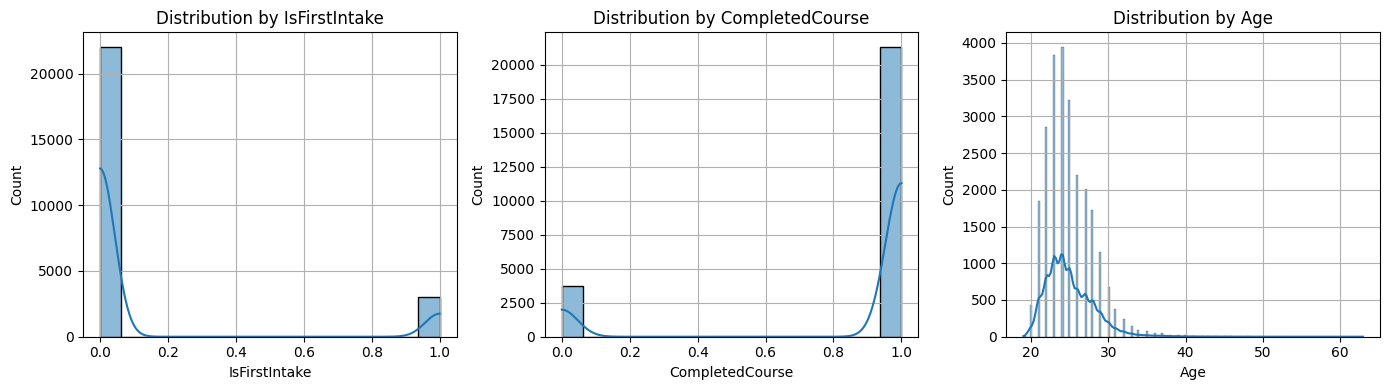

In [ ]:
# Visualise the numerical variables
# list of int64 type columns
int_cols = data.select_dtypes(include='int64').columns

plt.figure(figsize=(14,4))

for i, col in enumerate(int_cols):
    plt.subplot(1,len(int_cols),i+1)
    sns.histplot(data=data[int_cols],x=col,kde=True)
    plt.title(f'Distribution by {col}')
    plt.grid()
    plt.tight_layout()

plt.show() # Note-to-self: should be outside the loop to keep subplot structure

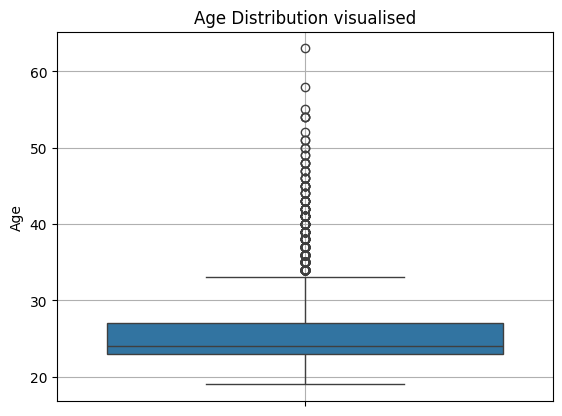

In [ ]:
# Inspect outliers for Age feature
plt.title('Age Distribution visualised')
sns.boxplot(data=data['Age'])
plt.grid()

Due to the large number of categories per feature, only the 10 most frequent values are displayed on the graphs below, while the remaining are grouped under 'Other'.

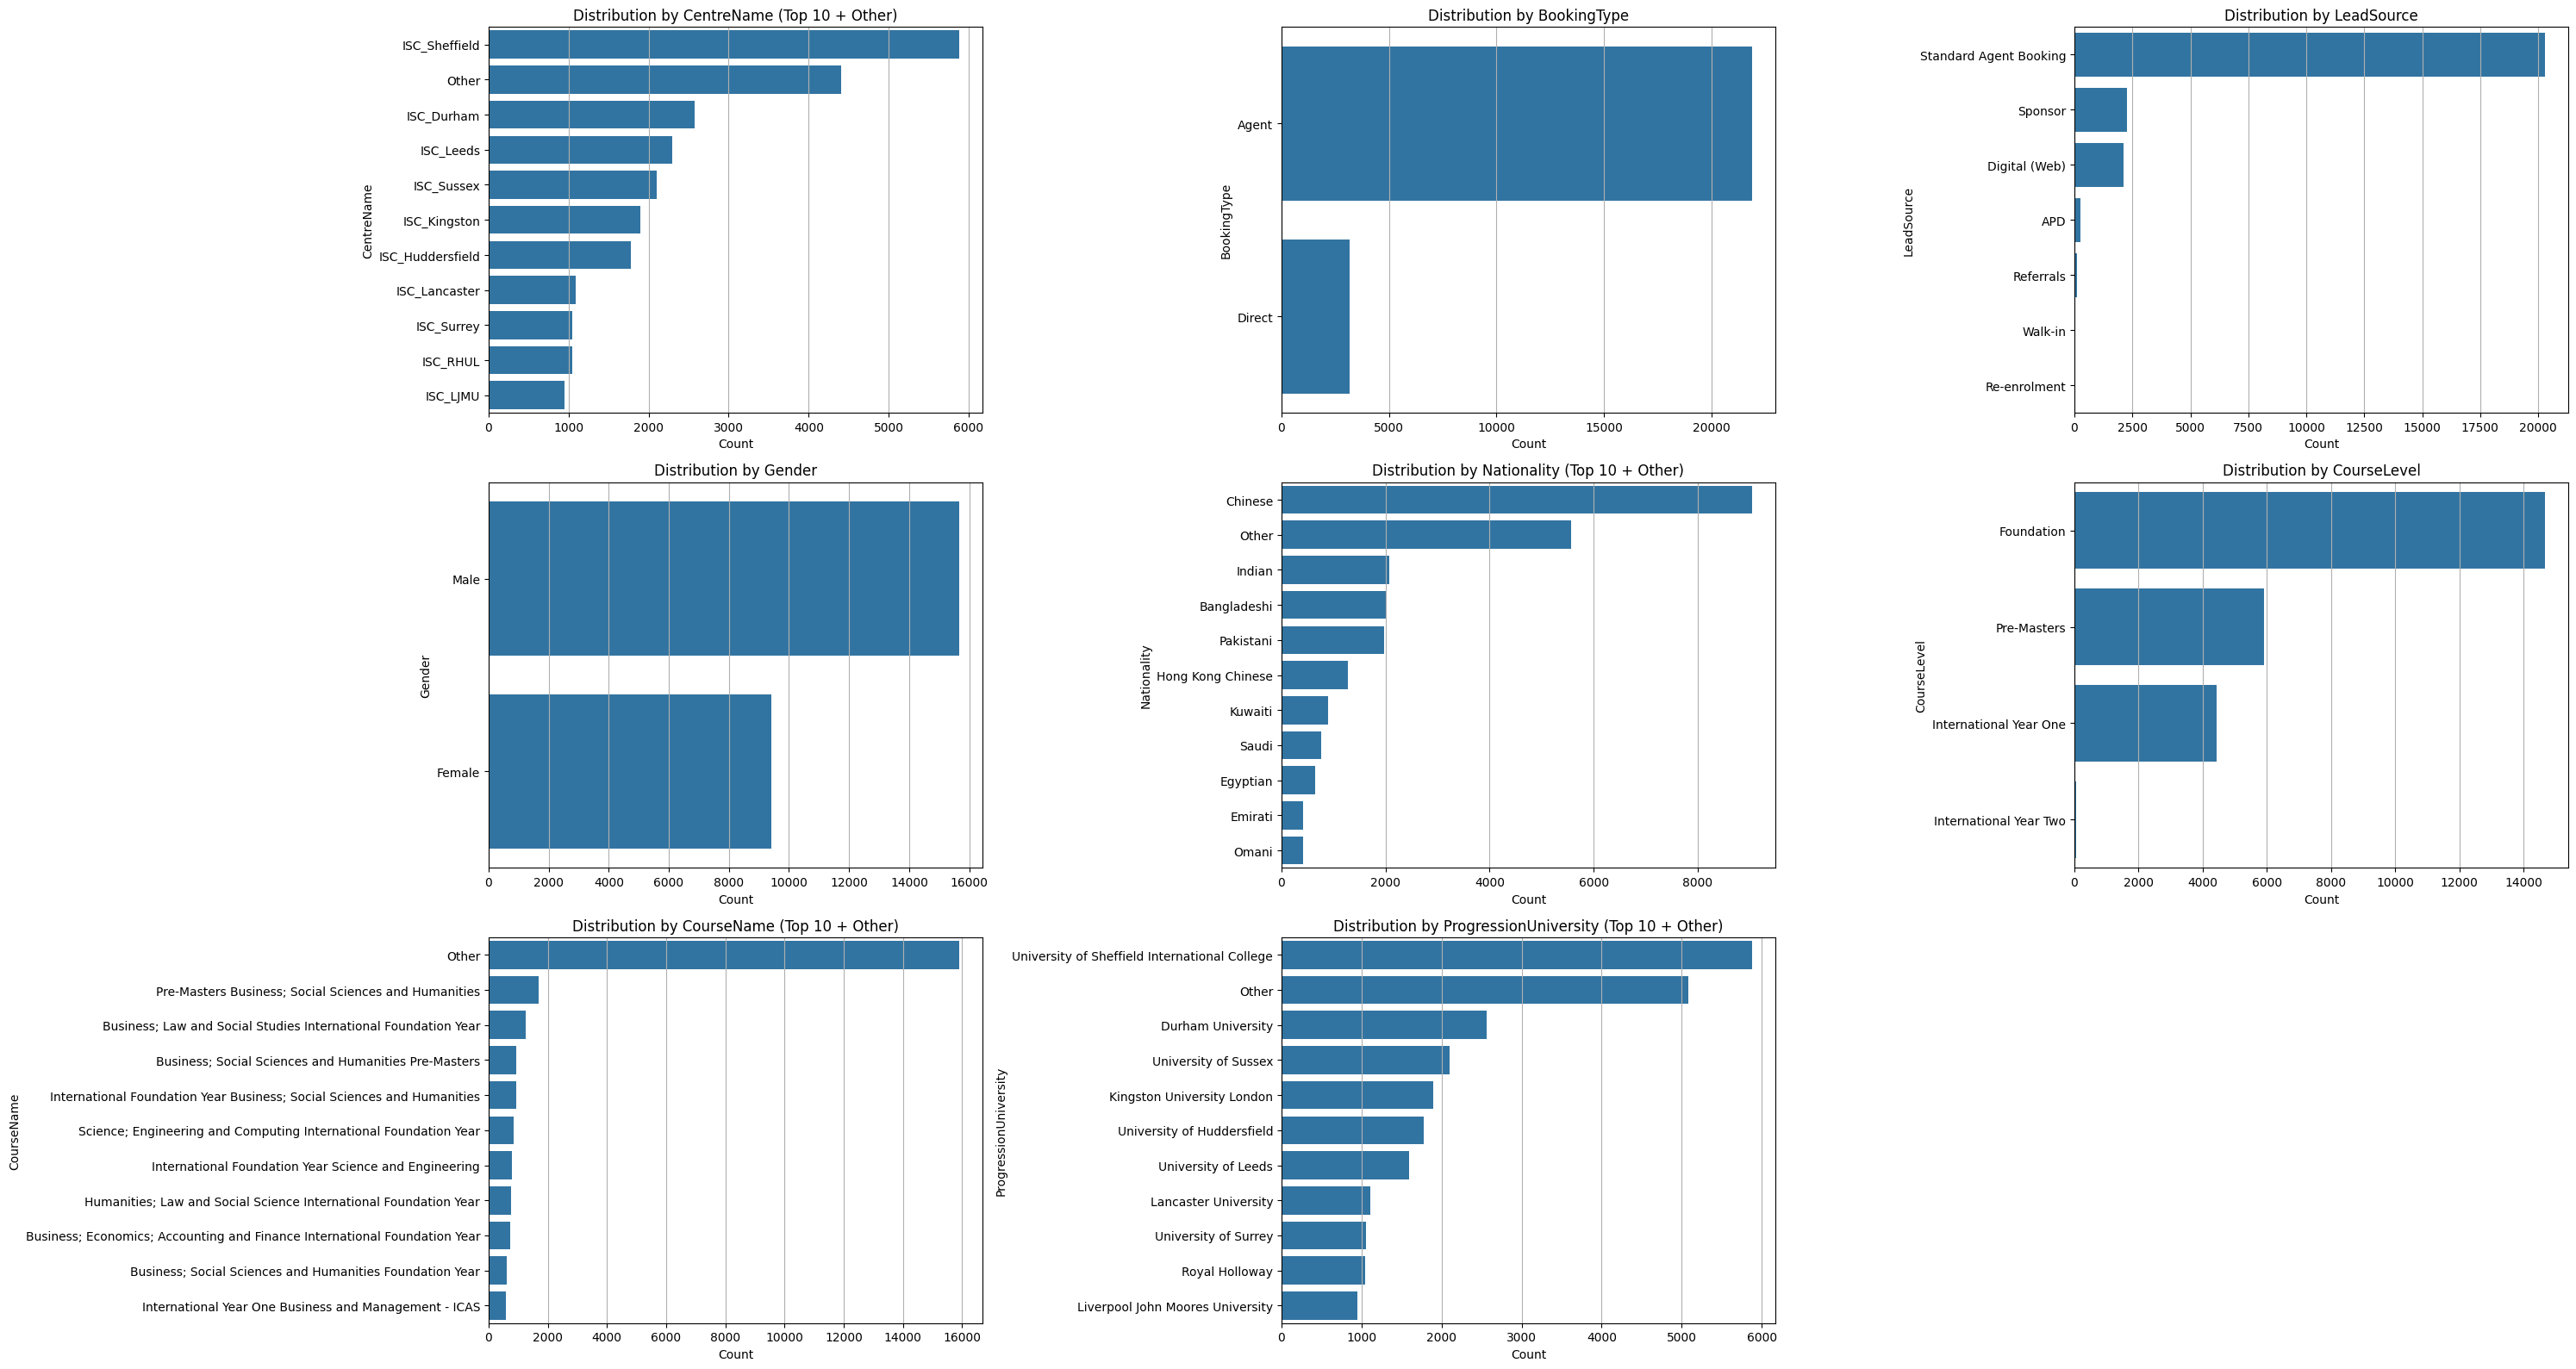

In [ ]:
# Visualise the categorical features
obj_cols = data.select_dtypes(include='object').columns

# Number of categorical columns
num_obj_cols = len(obj_cols)
plt.figure(figsize=(30,16))

for i, col in enumerate(obj_cols):
    plt.subplot(3,3,i+1)
    top_n = 10 # Number of categories to show
    # Check if column grouping is needed
    if data[col].nunique() > top_n:
        top_categories = data[col].value_counts().nlargest(top_n).index.tolist()
        grouped_data = data[col].apply(lambda x: x if x in top_categories else 'Other').copy()
        sns.countplot(data=None, y=grouped_data, order=grouped_data.value_counts().index)
        plt.title(f'Distribution by {col} (Top {top_n} + Other)')

    else:
        sns.countplot(data=data, y=col, order=data[col].value_counts().index)
        plt.title(f'Distribution by {col}') # Title without 'Top N + Other'

    plt.xlabel('Count')
    plt.grid(axis='x') # Horizontal grid lines for better visualisation
plt.tight_layout()
plt.show()

In [ ]:
# Review categories for Course Levels
data['CourseLevel'].unique()

array(['Pre-Masters', 'Foundation', 'International Year Two',
       'International Year One'], dtype=object)

In [ ]:
# Import encoders and convert features
from sklearn.preprocessing import OrdinalEncoder

# One-Hot-Encoding using pandas for obj-type features
data = pd.get_dummies(data,columns=['CentreName','BookingType','LeadSource','Gender','Nationality','CourseName','ProgressionUniversity'],
                      dtype=int)

# Ordinal encoding Ordinal feature: Course Level
OE = OrdinalEncoder(categories=[['Foundation','International Year One', 'International Year Two', 'Pre-Masters']])
data['CourseLevel'] = OE.fit_transform(data[['CourseLevel']])
data['CourseLevel'] = data['CourseLevel'].astype(int)

data.head()

,CourseLevel,IsFirstIntake,CompletedCourse,Age,CentreName_ISC_Aberdeen,CentreName_ISC_Cardiff,CentreName_ISC_Dublin,CentreName_ISC_Durham,CentreName_ISC_Holland,CentreName_ISC_Huddersfield,...,ProgressionUniversity_University College Dublin,ProgressionUniversity_University of Aberdeen,ProgressionUniversity_University of Huddersfield,ProgressionUniversity_University of Leeds,ProgressionUniversity_University of Lincoln,ProgressionUniversity_University of Sheffield International College,ProgressionUniversity_University of Strathclyde,ProgressionUniversity_University of Surrey,ProgressionUniversity_University of Sussex,ProgressionUniversity_VU Amsterdam
0,3,1,1,27,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,1,27,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2,0,1,25,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,2,1,1,26,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,3,1,1,29,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [ ]:
# Define the dataset & target variable
y = data['CompletedCourse'].copy()
x = data.drop(['CompletedCourse'],axis=1).copy()

# Split the data into Train/Test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)

# Scale the training data (necessary for the NN, non-consequential for XGBoost)
from sklearn.preprocessing import StandardScaler, RobustScaler

scaler = RobustScaler()  # using robust as there are outliers in the age feature
x_train['Age'] = scaler.fit_transform(x_train[['Age']])
x_test['Age'] = scaler.transform(x_test[['Age']])

# Define the Training & Validation sets for the NN
nn_x_train, nn_x_val, nn_y_train, nn_y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42,stratify=y_train)

In [ ]:
x_test.head()

,CourseLevel,IsFirstIntake,Age,CentreName_ISC_Aberdeen,CentreName_ISC_Cardiff,CentreName_ISC_Dublin,CentreName_ISC_Durham,CentreName_ISC_Holland,CentreName_ISC_Huddersfield,CentreName_ISC_Kingston,...,ProgressionUniversity_University College Dublin,ProgressionUniversity_University of Aberdeen,ProgressionUniversity_University of Huddersfield,ProgressionUniversity_University of Leeds,ProgressionUniversity_University of Lincoln,ProgressionUniversity_University of Sheffield International College,ProgressionUniversity_University of Strathclyde,ProgressionUniversity_University of Surrey,ProgressionUniversity_University of Sussex,ProgressionUniversity_VU Amsterdam
5665,1,0,0.00,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
2342,3,0,1.25,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6085,1,0,-0.75,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
8127,0,0,3.25,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4493,1,1,0.25,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0


In [ ]:
# Inspect distribution for the Training target feature
nn_y_train.value_counts(normalize=True)

,proportion
CompletedCourse,
1,0.850183
0,0.149817


In [ ]:
!pip install keras-tuner --upgrade

In [ ]:
# Import XGBoost, Neural networks with Keras, metrics, optimisers, tuning
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.layers import Input, Dense
from keras.optimizers import RMSprop, Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.metrics import Accuracy, Precision, Recall, AUC
import keras_tuner

## Neural Network & Tuning


In [ ]:
# Neural Network model
NN_Dropout = Sequential([
Input(shape=(nn_x_train.shape[1],)),
Dense(400,activation='relu'),
Dense(200,activation='relu'),
Dense(1,activation='sigmoid')])

NN_Dropout.summary()

#Define the evaluation metrics
keras_metrics = ['accuracy', 'precision', 'recall', 'AUC']

# Process pipeline
NN_Dropout.compile(loss='binary_crossentropy', optimizer='rmsprop',metrics=keras_metrics)   # produces better results than format ['accuracy']
History = NN_Dropout.fit(nn_x_train, nn_y_train, epochs=50, batch_size=64, validation_data=(nn_x_val, nn_y_val)) # verbose=2
Evaluation = NN_Dropout.evaluate(x_test, y_test)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 400)            │       158,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 200)            │        80,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 239,201 (934.38 KB)

 Trainable params: 239,201 (934.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - AUC: 0.8352 - accuracy: 0.8767 - loss: 0.3132 - precision: 0.8945 - recall: 0.9701 - val_AUC: 0.8926 - val_accuracy: 0.9002 - val_loss: 0.2570 - val_precision: 0.9155 - val_recall: 0.9724
Epoch 2/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - AUC: 0.8857 - accuracy: 0.8954 - loss: 0.2649 - precision: 0.9219 - recall: 0.9580 - val_AUC: 0.8972 - val_accuracy: 0.8958 - val_loss: 0.2500 - val_precision: 0.9207 - val_recall: 0.9601
Epoch 3/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - AUC: 0.8839 - accuracy: 0.8999 - loss: 0.2587 - precision: 0.9255 - recall: 0.9598 - val_AUC: 0.8946 - val_accuracy: 0.8933 - val_loss: 0.2566 - val_precision: 0.9085 - val_recall: 0.9724
Epoch 4/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - AUC: 0.8875 - accuracy: 0.8991 - loss: 0.2635 - precision: 0.9215 - recall: 0.9631 - val_AUC: 0.9007 - val_accuracy: 0.9032 - val_loss: 0.2501 - val_precision: 0.9232 - val_recall: 0.9666
Epoch 5/50
282/282 ━━━━━━━━━━━

Loss value: 0.3373956084251404 
Test Accuracy: 0.8800877928733826 
Test Precision: 0.9168564677238464 
Test Recall: 0.9446139335632324 
Test AUC: 0.8589622378349304 

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Confusion Matrix:


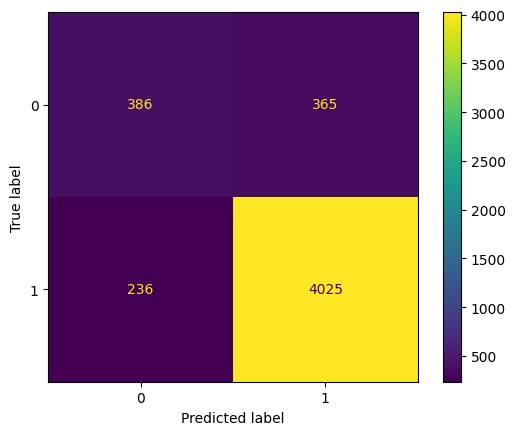

In [ ]:
# Print performance metrics on Test dataset
print('Loss value:',       Evaluation[0],
      '\nTest Accuracy:',  Evaluation[1],
      '\nTest Precision:', Evaluation[2],
      '\nTest Recall:',    Evaluation[3],
      '\nTest AUC:',       Evaluation[4],
      '\n')

# Create Confusion matrix
Predictions = NN_Dropout.predict(x_test)
y_pred = (Predictions >= 0.5).astype(int)
print('Confusion Matrix:')
cmds = ConfusionMatrixDisplay.from_predictions(y_test, y_pred,)


* True Positive = 4025 → Correctly predicted not dropping out

* True Negative = 386  → Correctly predicted dropping out

* False Negative = 236  → Actually not dropping out, predicted as dropping out

* False Positive = 365  → Actually dropping out, predicted as not dropping out

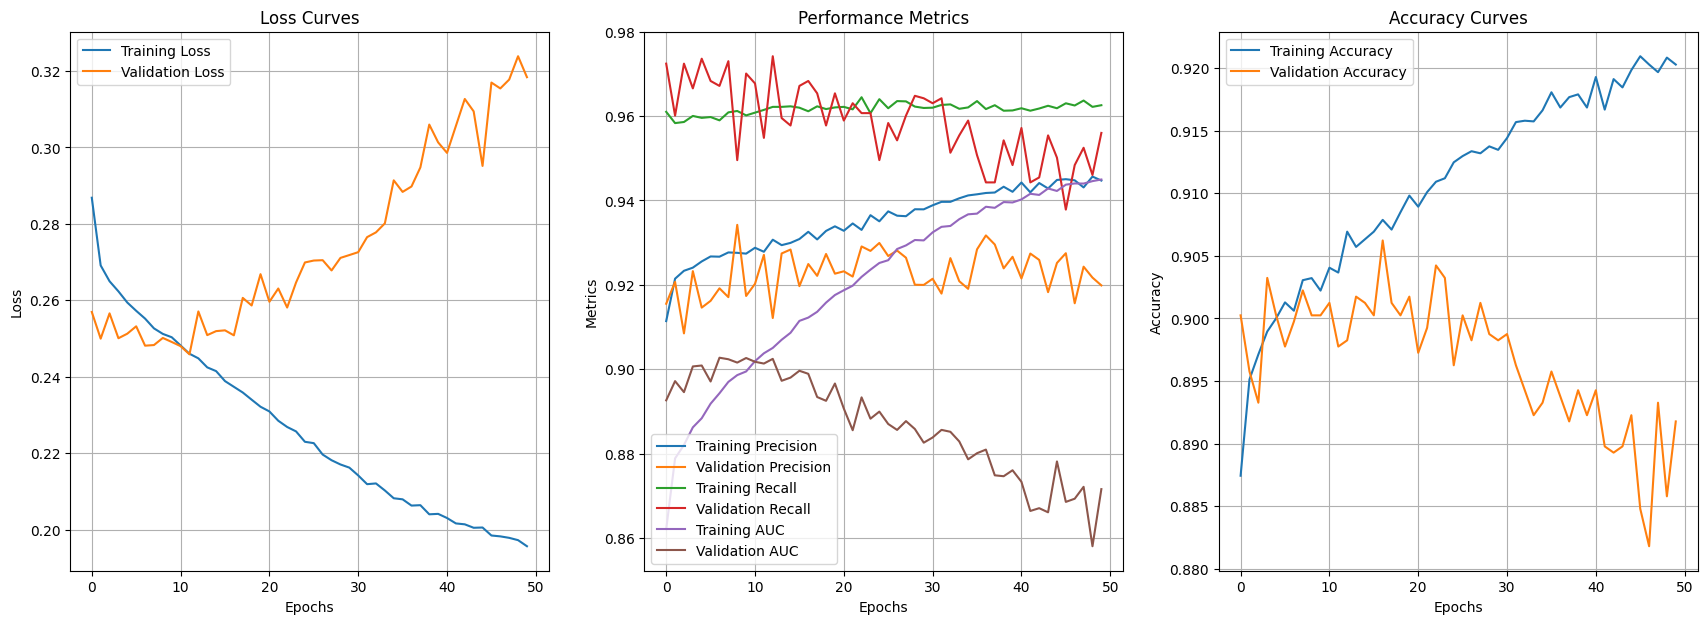

In [ ]:
# Plot Loss & performance curves for the training & validation sets
plt.figure(figsize=(21,7))
plt.subplot(1,3,1)
plt.plot(History.history['loss'], label='Training Loss')
plt.plot(History.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.grid()

plt.subplot(1,3,2)
plt.plot(History.history['precision'], label='Training Precision')
plt.plot(History.history['val_precision'], label='Validation Precision')
plt.plot(History.history['recall'], label='Training Recall')
plt.plot(History.history['val_recall'], label='Validation Recall')
plt.plot(History.history['AUC'], label='Training AUC')
plt.plot(History.history['val_AUC'], label='Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Performance Metrics')
plt.legend()
plt.grid()

plt.subplot(1,3,3)
plt.plot(History.history['accuracy'], label='Training Accuracy')
plt.plot(History.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()
plt.grid()

plt.show()

Examination of the Neural Network's training and validation loss curves indicated that overfitting commenced around epoch 10. This overfitting suggests that the model's generalisation ability was diminishing.

To mitigate this, an Early Stopping callback will be introduced during future training & tuning runs to halt the process before significant overfitting occurs.

Evaluating the default Neural Network's performance on the test set, the model achieved an average metric score of 89%, with a notable Recall of 0.937, but a lower AUC score of 0.858.

Trial 10 Complete [00h 01m 48s]
val_loss: 0.2559579461812973

Best val_loss So Far: 0.2464713677763939
Total elapsed time: 00h 23m 01s


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       203,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 96)             │        49,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 384)            │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 384)            │       147,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 224)            │        86,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 524,065 (2.00 MB)

 Trainable params: 524,065 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

None

Best hyperparameters found by the tuner:
{'units': 512, 'optimizer': 'sgd', 'activation': 'relu', 'num_layers': 5, 'units_0': 512, 'learning_rate_adam': 0.005766746418921648, 'units_1': 96, 'units_2': 384, 'units_3': 384, 'units_4': 224, 'learning_rate_sgd': 0.007560585479298688}
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.8746 - accuracy: 0.8992 - loss: 0.2695 - precision: 0.9247 - recall: 0.9607
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Comparison of Default and Tuned Model Metrics on Test Data:


,Default model,Tuned model
Loss,0.337396,0.268748
Accuracy,0.880088,0.895251
Precision,0.916856,0.921670
Recall,0.944614,0.958226
AUC,0.858962,0.883869


Confusion Matrix:


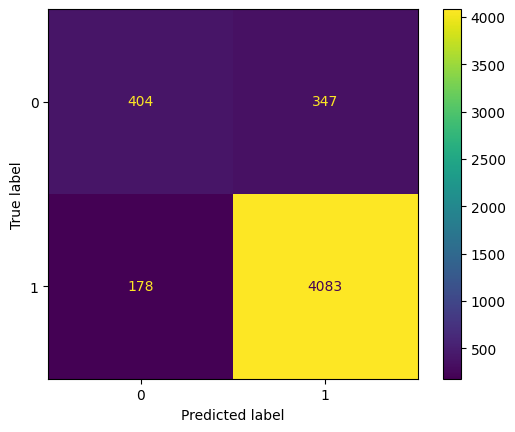

In [ ]:
# Import tuner modules
from keras_tuner import RandomSearch, Hyperband

# 1. Define the model builder function & hyperparameter search space
def build_model(hp):
  NN_tuned = Sequential()
  # Input layer
  NN_tuned.add(Input(shape=(nn_x_train.shape[1],)))
  # Hyperparameters
  neuron_count = hp.Int('units', min_value=32, max_value=512, step=32) #units=hp.Int(f'units_{i}' > n_neurons in each layer
  opt_func = hp.Choice('optimizer', ['adam','rmsprop','sgd'])
  actv_func = hp.Choice('activation', ['relu', 'tanh'])

  # Hidden layers
  for i in range(hp.Int('num_layers', 1, 5)):
    neuron_count = hp.Int(f'units_{i}', min_value=32, max_value=512, step=32) ### EACH LAYER HAS DIFFERENT NEURON COUNTS
    NN_tuned.add(Dense(units=neuron_count, activation=actv_func))
  # Output layer
  NN_tuned.add(Dense(units=1, activation='sigmoid'))

  # Adjust optimiser's learning rate
  if opt_func == 'adam':
    opt_func = Adam(learning_rate=hp.Float('learning_rate_adam', min_value=1e-4, max_value=1e-2, sampling='log'))
  elif opt_func == 'rmsprop':
    opt_func = RMSprop(learning_rate=hp.Float('learning_rate_adam', min_value=1e-4, max_value=1e-2, sampling='log'))
  elif opt_func == 'sgd':
    opt_func = SGD(learning_rate=hp.Float('learning_rate_sgd', min_value=1e-4, max_value=1e-2, sampling='log'))

  # Compile
  NN_tuned.compile(loss='binary_crossentropy', optimizer=opt_func, metrics=keras_metrics)
  return NN_tuned

  # Build the model
build_model(keras_tuner.HyperParameters())

# 2. Instantiate & Run the Search
tuner = RandomSearch(hypermodel=build_model, objective='val_loss',
                     max_trials=10, executions_per_trial=2,
                     overwrite=True, directory='my_dir',
                     project_name='student_dropout_NN_tuned')
# Get a summary
tuner.search_space_summary()
# Run search
tuner.search(nn_x_train, nn_y_train, epochs=50, validation_data=(nn_x_val, nn_y_val),
             callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

# 3. Explore results
# Best Model
best_model = tuner.get_best_models(num_models=1)[0]
print(best_model.summary())
# Best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\nBest hyperparameters found by the tuner:")
print(best_hps.values)

# 4. Evaluate
Evaluation_Tuned = best_model.evaluate(x_test, y_test)

# 5. Predict & Compare models
Tuned_pred = best_model.predict(x_test)
y_tuned_pred = (Tuned_pred >= 0.5).astype(int)

# Comparing Default & Tuned Model prediction metrics (on TEST data)
output_comparison = {'Default model': Evaluation, 'Tuned model': Evaluation_Tuned}
metric_names = ['Loss', 'Accuracy', 'Precision', 'Recall', 'AUC']
metrics_result = pd.DataFrame(output_comparison, index=metric_names)
print("\nComparison of Default and Tuned Model Metrics on Test Data:")
display(metrics_result) # Use display for better formatting in Colab
print('Confusion Matrix:')
cmds = ConfusionMatrixDisplay.from_predictions(y_test, y_tuned_pred)

## XGBoost & Tuning


Test Accuracy: 0.8944533120510774
Test Precision: 0.921028880866426
Test Recall: 0.957991081905656
Test AUC: 0.7459729044681409
Confusion Matrix for XGB:


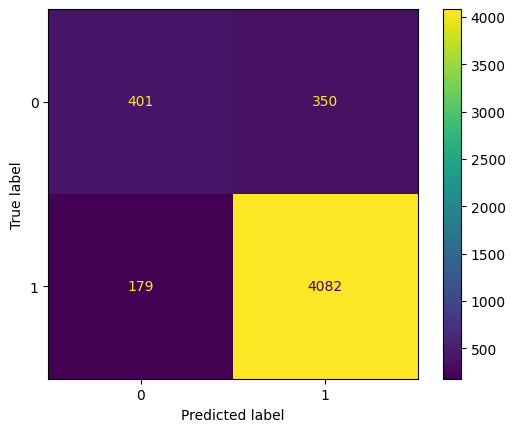

In [ ]:
## The XGBOOST model fitted on the training dataset (use 80-20 split)
XGB_Dropped = XGBClassifier(random_state=42)
XG_trained = XGB_Dropped.fit(x_train, y_train)
XGB_pred = XGB_Dropped.predict(x_test)

# Calculate the metric performances for the XGB model
default_accuracy = accuracy_score(y_test, XGB_pred)
default_precision = precision_score(y_test, XGB_pred)
default_recall = recall_score(y_test, XGB_pred)
default_roc_auc = roc_auc_score(y_test, XGB_pred)

print('Test Accuracy:', default_accuracy)
print('Test Precision:', default_precision)
print('Test Recall:', default_recall)
print('Test AUC:', default_roc_auc)
print('Confusion Matrix for XGB:')
XGB_cmds = ConfusionMatrixDisplay.from_predictions(y_test, XGB_pred)

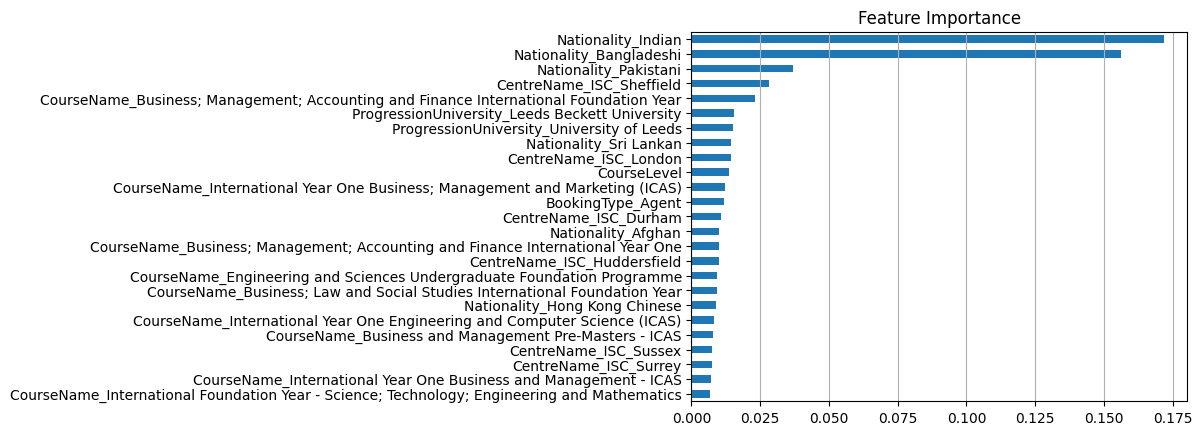

In [ ]:
# Plot the features importance and comment on the insights
feature_importance = pd.Series(XG_trained.feature_importances_, index=x_train.columns).sort_values()
feature_importance.iloc[-25:].plot.barh(title='Feature Importance') # show only the top most 25
plt.grid(axis='x')

Among the student demographic and course-related features for Stage 1, nationality emerged as a significant predictor of potential dropout, with a notable association for students identifying as Indian/Pakistani/Bangladeshi. This insight provides the client with the opportunity to implement proactive measures during the pre-enrolment phase. By identifying this demographic as potentially at-risk, the company can develop and offer targeted support, orientation programmes, or resources tailored to the specific needs of these students, thereby increasing their likelihood of successful course completion.

#### Grid/RandomizerSearchCV:

In the process of tuning the XGBoost model, both RandomizedSearchCV and GridSearchCV were employed. As the results obtained from these two approaches were nearly identical, the following sections will highlight the application and outcomes of one of these tuning methods respectively.

In [ ]:
"""
# For RandomizedSearchCV
# Define the parameter distribution
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
param_dist = {'n_estimators': randint(100, 500),    # Sample from integers between 100 and 500
              'max_depth': randint(3, 10),          # Sample from integers between 3 and 10
              'learning_rate': uniform(0.01, 0.1)}  # Sample from a uniform distribution between 0.01 and 0.1
"""

"# For RandomizedSearchCV\n# Define the parameter distribution\nfrom sklearn.model_selection import RandomizedSearchCV\nfrom scipy.stats import uniform, randint\nparam_dist = {'n_estimators': randint(100, 500),    # Sample from integers between 100 and 500\n              'max_depth': randint(3, 10),          # Sample from integers between 3 and 10\n              'learning_rate': uniform(0.01, 0.1)}  # Sample from a uniform distribution between 0.01 and 0.1\n"

In [ ]:
# Import the necessary module
from sklearn.model_selection import GridSearchCV
# Define the Grid to be used in the search
grid = {'learning_rate':[0.01, 0.05, 0.1],
        'max_depth':[3, 6, 12],
        'n_estimators':[100, 200, 300]}
# Define the evaluation metrics to calculate
sklearn_metrics = ['accuracy', 'precision', 'recall', 'roc_auc']

# Instantiate the GridSearch with relevant parameters
XGB_GridSearch = GridSearchCV(XGB_Dropped,
                              param_grid=grid,
                              scoring=sklearn_metrics,
                              cv=5, verbose=2,
                              refit='roc_auc', return_train_score=True)
                              # Refit on a single metric, 'roc_auc' is good for imbalanced data
# Apply the GS to the model
XGB_GridSearch.fit(x_train, y_train)
# Explore outputs
print(XGB_GridSearch.best_params_) #Show the best parameters
print(XGB_GridSearch.best_estimator_) #Show the best model settings
print(XGB_GridSearch.best_score_) #Show the cross-validated score for the estimator specified in refit arg
#print(XGB_GridSearch.cv_results_) #Dictionary with keys and values

# Define the tuned model with best parameters
XGB_Tuned = XGB_GridSearch.best_estimator_

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   1.2s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   1.7s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   1.2s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   1.2s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   1.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   1.9s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   1.9s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   2.9s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   1.9s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   1.8s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=300; total time=   2.5s
[CV] END ..learning_rate=0.01, max_depth=3, n_e

In [ ]:
# Explore outputs
print(XGB_GridSearch.best_params_) #Show the best parameters
print(XGB_GridSearch.best_estimator_) #Show the best model settings
print(XGB_GridSearch.best_score_) #Show the cross-validated score for the estimator specified in refit arg
#print(XGB_GridSearch.cv_results_) #Dictionary with keys and values

{'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200}
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)
0.8822793621417067


Test Accuracy: 0.8944533120510774
Test Precision: 0.9174496644295302
Test Recall: 0.9624501290776813
Test AUC: 0.7355526277878419
Confusion Matrix for Tuned XGB:


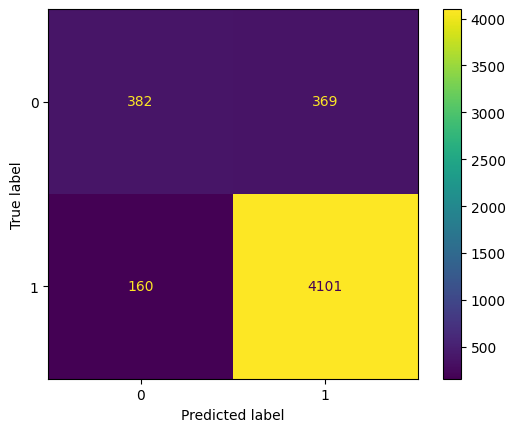

In [ ]:
# Define the tuned model with best parameters
XGB_Tuned = XGB_GridSearch.best_estimator_
# Predict outputs using tuned models & display performance metrics
XGB_GridSearch_pred = XGB_Tuned.predict(x_test)

tuned_accuracy = accuracy_score(y_test, XGB_GridSearch_pred)
tuned_precision = precision_score(y_test, XGB_GridSearch_pred)
tuned_recall = recall_score(y_test, XGB_GridSearch_pred)
tuned_roc_auc = roc_auc_score(y_test, XGB_GridSearch_pred)

print('Test Accuracy:', tuned_accuracy)
print('Test Precision:', tuned_precision)
print('Test Recall:', tuned_recall)
print('Test AUC:', tuned_roc_auc)
print('Confusion Matrix for Tuned XGB:')
XG_tuned_cmds = ConfusionMatrixDisplay.from_predictions(y_test, XGB_GridSearch_pred)

In [ ]:
# Compare default & tuned XGB models
print("Performance Comparison (Test Set):")
print("-" * 40)
print(f"{'Metric':<15} {'Default Model':<15} {'Tuned Model':<15}")
print("-" * 40)
print(f"{'Accuracy':<15} {default_accuracy:<15.4f} {tuned_accuracy:<15.4f}")
print(f"{'Precision':<15} {default_precision:<15.4f} {tuned_precision:<15.4f}")
print(f"{'Recall':<15} {default_recall:<15.4f} {tuned_recall:<15.4f}")
print(f"{'AUC':<15} {default_roc_auc:<15.4f} {tuned_roc_auc:<15.4f}")
print("-" * 40)

# Further details
print("\nBest hyperparameters found by GridSearch:")
print(XGB_GridSearch.best_params_)

Performance Comparison (Test Set):
----------------------------------------
Metric          Default Model   Tuned Model    
----------------------------------------
Accuracy        0.8945          0.8945         
Precision       0.9210          0.9174         
Recall          0.9580          0.9625         
AUC             0.7460          0.7356         
----------------------------------------

Best hyperparameters found by GridSearch:
{'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200}


#### Commentary

Stage 1 Data provided foundational student and course enrollment data on which the predictive models were trained, tuned and evaluated. The Neural network produced overall better results than the XGBoost decision tree.

While providing initial predictive power, evidenced by the baseline AUC (88% for NN, 74% for XGBoost), the models were limited in their ability to fully capture the complexities associated with student dropout.

# Stage 2 data

In [ ]:
# File URL
file_url_2 = "classified"

**Stage 2: Pre-processing**

- Remove any columns not useful in the analysis (LearnerCode).
- Remove columns with high cardinality (use >200 unique values, as a guideline).
- Remove columns with >50% data missing.
- Perform ordinal encoding for ordinal data.
- Perform one-hot encoding for all other categorical data.
- Impute missing data rows with appropriate values.
- Remove rows with missing values in cases where rows with missing values are minimal: <2% of the overall data.



In [ ]:
data_s2 = pd.read_csv(file_url_2)
data_s2.head()

,CentreName,LearnerCode,BookingType,LeadSource,DiscountType,DateofBirth,Gender,Nationality,HomeState,HomeCity,CourseLevel,CourseName,IsFirstIntake,CompletedCourse,ProgressionDegree,ProgressionUniversity,AuthorisedAbsenceCount,UnauthorisedAbsenceCount
0,ISC_Aberdeen,2284932,Agent,Standard Agent Booking,NaN,13/01/1998,Male,Chinese,Jianye District; Jiangsu Province,Nanjing,Pre-Masters,Business and Law Pre-Masters,True,Yes,Msc Econ Accounting and Investment Management,University of Aberdeen,NaN,NaN
1,ISC_Aberdeen,2399500,Agent,Standard Agent Booking,NaN,12/2/1998,Male,Chinese,NaN,Xi'an,Foundation,Life Sciences Undergraduate Foundation Programme,False,Yes,BSc Biological Sciences,University of Aberdeen,93.0,5.0
2,ISC_Aberdeen,2424946,Agent,Standard Agent Booking,NaN,7/4/2000,Male,Chinese,NaN,Chengdu,International Year Two,Business Management and Finance International ...,False,Yes,MA Finance,University of Aberdeen,92.0,6.0
3,ISC_Aberdeen,2426583,Agent,Standard Agent Booking,NaN,18/05/1999,Male,Chinese,NaN,LIUYANG CITY ;CHANGSHA,International Year Two,Business Management and Finance International ...,True,Yes,MA Business Management,University of Aberdeen,67.0,15.0
4,ISC_Aberdeen,2434674,Agent,Standard Agent Booking,NaN,19/04/1996,Male,Chinese,NaN,Xiamen,Pre-Masters,Business and Law Pre-Masters,True,Yes,MSc International Business Management,University of Aberdeen,NaN,NaN


In [ ]:
# Check data types, unique & missing values per feature
data_s2.info()
print('\n Unique values per feature \n', data_s2.nunique())
print('\n Missing values per feature \n', data_s2.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25059 entries, 0 to 25058
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CentreName                25059 non-null  object 
 1   LearnerCode               25059 non-null  int64  
 2   BookingType               25059 non-null  object 
 3   LeadSource                25059 non-null  object 
 4   DiscountType              7595 non-null   object 
 5   DateofBirth               25059 non-null  object 
 6   Gender                    25059 non-null  object 
 7   Nationality               25059 non-null  object 
 8   HomeState                 8925 non-null   object 
 9   HomeCity                  21611 non-null  object 
 10  CourseLevel               25059 non-null  object 
 11  CourseName                25059 non-null  object 
 12  IsFirstIntake             25059 non-null  bool   
 13  CompletedCourse           25059 non-null  object 
 14  Progre

In [ ]:
# Convert data types
data_s2['DateofBirth'] = pd.to_datetime(data_s2['DateofBirth'], dayfirst=True)
today = pd.Timestamp.now()
data_s2['Age'] = (today - data_s2['DateofBirth']).dt.days / 365.25
data_s2['Age'] = data_s2['Age'].round(0).astype(int)

# Convert Target variable Yes & No column to boolean values
data_s2['CompletedCourse'] = data_s2['CompletedCourse'].map({'Yes': 1, 'No': 0}) #.astype(bool)
data_s2['IsFirstIntake'] = data_s2['IsFirstIntake'].astype(int)

data_s2.drop(['LearnerCode','DateofBirth','HomeCity','HomeState','DiscountType', 'ProgressionDegree'], axis=1, inplace=True)

In [ ]:
data_s2.describe().round(2)

,IsFirstIntake,CompletedCourse,AuthorisedAbsenceCount,UnauthorisedAbsenceCount,Age
count,25059.00,25059.00,24851.00,24851.00,25059.00
mean,0.12,0.85,15.12,40.49,24.99
std,0.33,0.36,28.92,39.03,3.17
min,0.00,0.00,0.00,0.00,19.00
25%,0.00,1.00,0.00,12.00,23.00
50%,0.00,1.00,1.00,29.00,24.00
75%,0.00,1.00,15.00,56.00,27.00
max,1.00,1.00,292.00,343.00,63.00


In [ ]:
# Impute missing data
data_s2['AuthorisedAbsenceCount'].fillna(data_s2['AuthorisedAbsenceCount'].median(),inplace=True)
data_s2['UnauthorisedAbsenceCount'].fillna(data_s2['UnauthorisedAbsenceCount'].median(),inplace=True)

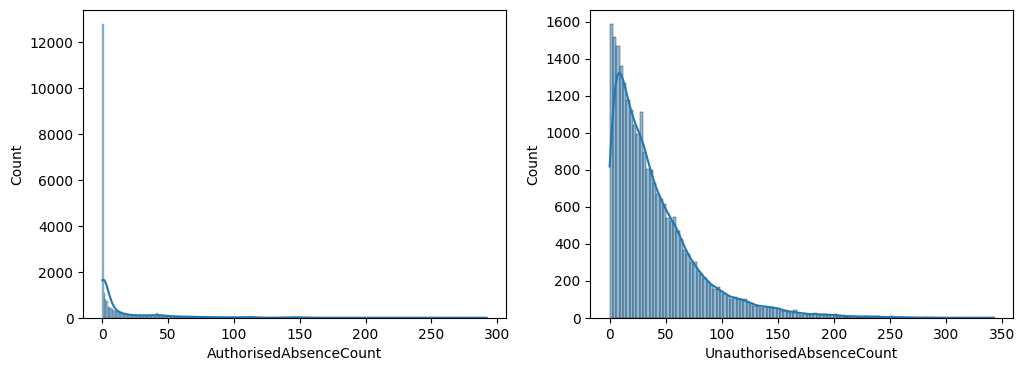

In [ ]:
# Plotted the distributions of the new features
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(data_s2['AuthorisedAbsenceCount'], kde=True)
plt.subplot(1,2,2)
sns.histplot(data_s2['UnauthorisedAbsenceCount'], kde=True)
plt.show()

<Axes: >

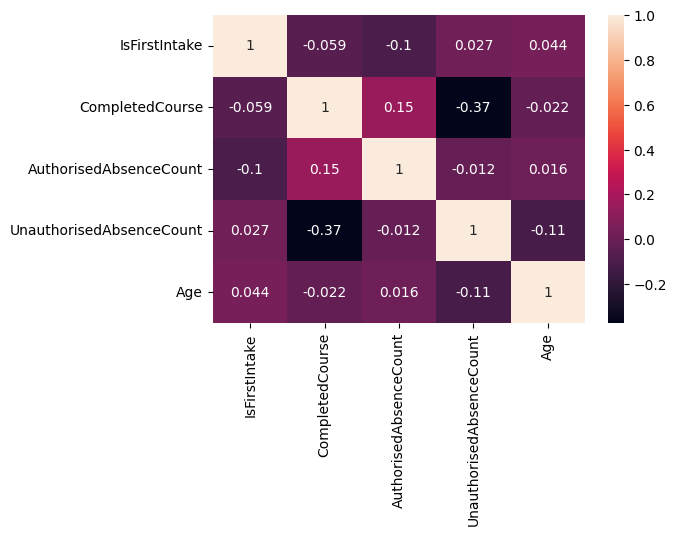

In [ ]:
# Review any notable correlations for the new features
data_s2.corr(numeric_only=True)
plt.figure(figsize=(6,4))
sns.heatmap(data_s2.corr(numeric_only=True),annot=True)

The plot above indicates that there is a moderately significant negative correlation (-0.37) between the number of **Unauthorised Absences** & the **Course Completion** likelihood.

In [ ]:
# One-Hot-Encoding using pandas for obj-type features
data_s2 = pd.get_dummies(data_s2,columns=['CentreName','BookingType','LeadSource','Gender','Nationality','CourseName','ProgressionUniversity'],
                      dtype=int) # drop_first=True -- reduce number of columns by n-1 per feature

# Ordinal encoding Ordinal feature: Course Level
OE = OrdinalEncoder(categories=[['Foundation','International Year One', 'International Year Two', 'Pre-Masters']])
data_s2['CourseLevel'] = OE.fit_transform(data_s2[['CourseLevel']])
data_s2['CourseLevel'] = data_s2['CourseLevel'].astype(int)


# Define the dataset & target variable (ONCE SCALING,TRANSFORMATIONS & ENCODING IS DONE)
y2 = data_s2['CompletedCourse'].copy()
x2 = data_s2.drop(['CompletedCourse'],axis=1).copy()

# Split the data into Train/Test
x2_train, x2_test, y2_train, y2_test = train_test_split(x2,y2,test_size=0.2,random_state=42,stratify=y2)

# Scale the training data (necessary for the NN, non-consequential for XGBoost)
scaler = RobustScaler()  # I am using robust as there are outliers in the age feature
x2_train[['Age','AuthorisedAbsenceCount','UnauthorisedAbsenceCount']] = scaler.fit_transform(x2_train[['Age','AuthorisedAbsenceCount','UnauthorisedAbsenceCount']])
x2_test[['Age','AuthorisedAbsenceCount','UnauthorisedAbsenceCount']] = scaler.transform(x2_test[['Age','AuthorisedAbsenceCount','UnauthorisedAbsenceCount']])

# Define the Training & Validation sets for the NN
nn_x2_train, nn_x2_val, nn_y2_train, nn_y2_val = train_test_split(x2_train, y2_train, test_size=0.1, random_state=42,stratify=y2_train)

In [ ]:
x2_train.head()

,CourseLevel,IsFirstIntake,AuthorisedAbsenceCount,UnauthorisedAbsenceCount,Age,CentreName_ISC_Aberdeen,CentreName_ISC_Cardiff,CentreName_ISC_Dublin,CentreName_ISC_Durham,CentreName_ISC_Holland,...,ProgressionUniversity_University College Dublin,ProgressionUniversity_University of Aberdeen,ProgressionUniversity_University of Huddersfield,ProgressionUniversity_University of Leeds,ProgressionUniversity_University of Lincoln,ProgressionUniversity_University of Sheffield International College,ProgressionUniversity_University of Strathclyde,ProgressionUniversity_University of Surrey,ProgressionUniversity_University of Sussex,ProgressionUniversity_VU Amsterdam
15349,3,0,-0.066667,-0.477273,1.25,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
24358,3,0,3.933333,0.363636,1.50,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
11293,0,0,0.866667,0.318182,-0.50,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
14439,1,0,1.066667,0.772727,-0.25,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13130,0,1,-0.066667,0.431818,0.50,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Neural Network & Tuning - Stage 2

In [ ]:
# Neural Network model
NN_Dropout2 = Sequential([
Input(shape=(nn_x2_train.shape[1],)),
Dense(400,activation='relu'),
Dense(200,activation='relu'),
Dense(1,activation='sigmoid')])

NN_Dropout2.summary()


# Define the evaluation metrics
keras_metrics = ['accuracy', 'precision', 'recall', 'AUC']
early_stop = EarlyStopping(monitor="val_loss", patience=5,
                           min_delta=0.001,
                           verbose=1,mode="auto", restore_best_weights=False,)

# Process pipeline
NN_Dropout2.compile(loss='binary_crossentropy', optimizer='rmsprop',metrics=keras_metrics)   # gives better results ['accuracy']
History_2 = NN_Dropout2.fit(nn_x2_train, nn_y2_train, epochs=50, batch_size=64, validation_data=(nn_x2_val, nn_y2_val), callbacks=early_stop, verbose=1) # verbose=2
Evaluation_2 = NN_Dropout2.evaluate(x2_test, y2_test)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 400)            │       159,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 200)            │        80,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 240,001 (937.50 KB)

 Trainable params: 240,001 (937.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - AUC: 0.8635 - accuracy: 0.8857 - loss: 0.2884 - precision: 0.9047 - recall: 0.9685 - val_AUC: 0.9137 - val_accuracy: 0.9027 - val_loss: 0.2403 - val_precision: 0.9384 - val_recall: 0.9478
Epoch 2/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9051 - accuracy: 0.9034 - loss: 0.2414 - precision: 0.9314 - recall: 0.9573 - val_AUC: 0.9192 - val_accuracy: 0.9112 - val_loss: 0.2330 - val_precision: 0.9385 - val_recall: 0.9584
Epoch 3/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9190 - accuracy: 0.9103 - loss: 0.2274 - precision: 0.9353 - recall: 0.9611 - val_AUC: 0.9208 - val_accuracy: 0.9082 - val_loss: 0.2341 - val_precision: 0.9294 - val_recall: 0.9654
Epoch 4/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9195 - accuracy: 0.9100 - loss: 0.2289 - precision: 0.9335 - recall: 0.9626 - val_AUC: 0.9201 - val_accuracy: 0.9112 - val_loss: 0.2300 - val_precision: 0.9355 - val_recall: 0.9619
Epoch 5/50
282/282 ━━━━━━━━━━━━━

In [ ]:
# Stage 2 NN Tuning
def build_model(hp):
  NN_tuned_s2 = Sequential()
  # Input layer
  NN_tuned_s2.add(Input(shape=(nn_x2_train.shape[1],)))
  # Hyperparameters
  neuron_count = hp.Int('units', min_value=32, max_value=512, step=32) #units=hp.Int(f'units_{i}' > n_neurons in each layer
  opt_func = hp.Choice('optimizer', ['adam','rmsprop','sgd'])
  actv_func = hp.Choice('activation', ['relu', 'tanh'])

  # Hidden layers
  for i in range(hp.Int('num_layers', 1, 5)):
    neuron_count = hp.Int(f'units_{i}', min_value=32, max_value=512, step=32) ### EACH LAYER HAS DIFFERENT NEURON COUNTS
    NN_tuned_s2.add(Dense(units=neuron_count, activation=actv_func))
  # Output layer
  NN_tuned_s2.add(Dense(units=1, activation='sigmoid'))

  # Adjust optimiser's learning rate
  if opt_func == 'adam':
    opt_func = Adam(learning_rate=hp.Float('learning_rate_adam', min_value=1e-4, max_value=1e-2, sampling='log'))
  elif opt_func == 'rmsprop':
    opt_func = RMSprop(learning_rate=hp.Float('learning_rate_adam', min_value=1e-4, max_value=1e-2, sampling='log'))
  elif opt_func == 'sgd':
    opt_func = SGD(learning_rate=hp.Float('learning_rate_sgd', min_value=1e-4, max_value=1e-2, sampling='log'))

  # Compile
  NN_tuned_s2.compile(loss='binary_crossentropy', optimizer=opt_func, metrics=keras_metrics)
  return NN_tuned_s2

  # Build the model
build_model(keras_tuner.HyperParameters())

# 2. Instantiate & Run the Search
tuner = RandomSearch(hypermodel=build_model, objective='val_loss',
                     max_trials=10, executions_per_trial=2,
                     overwrite=True, directory='my_dir',
                     project_name='student_dropout_NN_tuned')
# Get a summary
tuner.search_space_summary()
# Run search
tuner.search(nn_x2_train, nn_y2_train, epochs=50, validation_data=(nn_x2_val, nn_y2_val),
             callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

Trial 10 Complete [00h 01m 20s]
val_loss: 0.2387041449546814

Best val_loss So Far: 0.22938553243875504
Total elapsed time: 00h 24m 39s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 224)            │        89,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,601 (350.00 KB)

 Trainable params: 89,601 (350.00 KB)

 Non-trainable params: 0 (0.00 B)

None

Best hyperparameters found by the tuner:
{'units': 320, 'optimizer': 'rmsprop', 'activation': 'relu', 'num_layers': 1, 'units_0': 224, 'learning_rate_adam': 0.0009441488408008199}
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.8997 - accuracy: 0.9009 - loss: 0.2471 - precision: 0.9299 - recall: 0.9565
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Comparison of Default and Tuned Model Metrics on Stage 2 Test Data:


,Default model S2,Tuned model S2
Loss,0.246018,0.246416
Accuracy,0.903432,0.903232
Precision,0.933242,0.928701
Recall,0.954705,0.959869
AUC,0.908263,0.906100


Confusion Matrix for S2 Tuned NN:


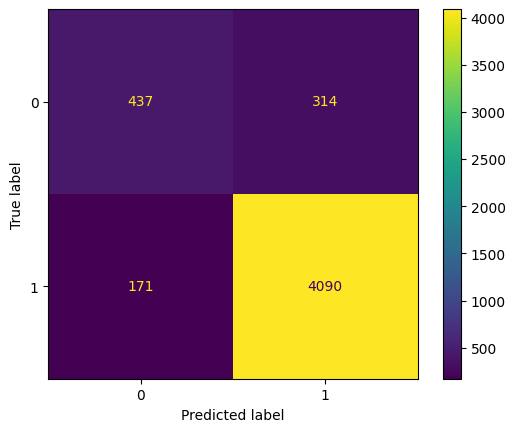

In [ ]:
# 3. Explore results
# Best Model
best_model_s2 = tuner.get_best_models(num_models=1)[0]
print(best_model_s2.summary())
# Best Hyperparameters
best_hps_s2 = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\nBest hyperparameters found by the tuner:")
print(best_hps_s2.values)

# 4. Evaluate
Evaluation_Tuned_s2 = best_model_s2.evaluate(x2_test, y2_test)

# 5. Predict & Compare models
Tuned_pred_s2 = best_model_s2.predict(x2_test)
y2_tuned_pred = (Tuned_pred_s2 >= 0.5).astype(int)

# Comparing Default & Tuned Model prediction metrics (on STAGE 2 TEST data)
output_comparison_s2 = {'Default model S2': Evaluation_2, 'Tuned model S2': Evaluation_Tuned_s2}
metric_names = ['Loss', 'Accuracy', 'Precision', 'Recall', 'AUC']
metrics_result_s2 = pd.DataFrame(output_comparison_s2, index=metric_names)
print("\nComparison of Default and Tuned Model Metrics on Stage 2 Test Data:")
display(metrics_result_s2) # Can use display for better formatting in Colab
print('Confusion Matrix for S2 Tuned NN:')
cmds = ConfusionMatrixDisplay.from_predictions(y2_test, y2_tuned_pred)

## XGBoost & Tuning - Stage 2

Test Accuracy: 0.9056264964086194
Test Precision: 0.9294784580498866
Test Recall: 0.9619807556911523
Test AUC: 0.7739331208548971
Confusion Matrix for S2 XGB:


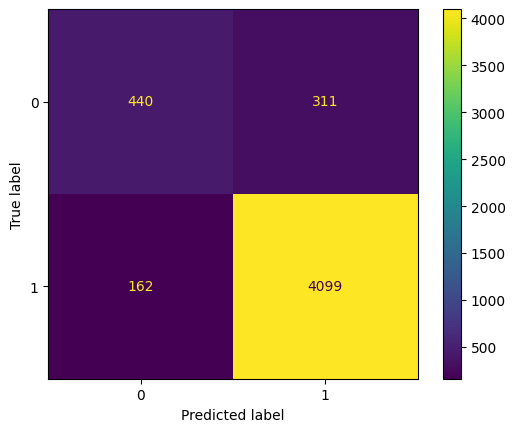

In [ ]:
# XGBOOST
## The XGBOOST model fitted on the training dataset
XGB_Dropped2 = XGBClassifier(random_state=42)
XG_trained2 = XGB_Dropped2.fit(x2_train, y2_train)
XGB_pred2 = XGB_Dropped2.predict(x2_test)

# Calculate the metric performances for the XGB model
default_accuracy2 = accuracy_score(y2_test, XGB_pred2)
default_precision2 = precision_score(y2_test, XGB_pred2)
default_recall2 = recall_score(y2_test, XGB_pred2)
default_roc_auc2 = roc_auc_score(y2_test, XGB_pred2)

print('Test Accuracy:', default_accuracy2)
print('Test Precision:', default_precision2)
print('Test Recall:', default_recall2)
print('Test AUC:', default_roc_auc2)
print('Confusion Matrix for S2 XGB:')
XGB_cmds2 = ConfusionMatrixDisplay.from_predictions(y2_test, XGB_pred2)

In [ ]:
# Tuning XGB2 using RandomizedSearchCV
from scipy.stats import randint, uniform
param_dist = {'n_estimators':randint(100,500),
              'max_depth':randint(3,12),
              'learning_rate':uniform(0.01,0.1)}

sklearn_metrics = ['accuracy', 'precision', 'recall', 'roc_auc']

XGB2_RandomSearch = RandomizedSearchCV(XGB_Dropped2, param_distributions=param_dist,
                                       scoring=sklearn_metrics, cv=5, verbose=2,
                                       refit='roc_auc', return_train_score=True)
XGB2_RandomSearch.fit(x2_train, y2_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END learning_rate=0.05295537724284872, max_depth=5, n_estimators=293; total time=   2.9s
[CV] END learning_rate=0.05295537724284872, max_depth=5, n_estimators=293; total time=   2.9s
[CV] END learning_rate=0.05295537724284872, max_depth=5, n_estimators=293; total time=   4.1s
[CV] END learning_rate=0.05295537724284872, max_depth=5, n_estimators=293; total time=   2.9s
[CV] END learning_rate=0.05295537724284872, max_depth=5, n_estimators=293; total time=   2.9s
[CV] END learning_rate=0.09757709112995581, max_depth=6, n_estimators=377; total time=   4.6s
[CV] END learning_rate=0.09757709112995581, max_depth=6, n_estimators=377; total time=   3.5s
[CV] END learning_rate=0.09757709112995581, max_depth=6, n_estimators=377; total time=   3.4s
[CV] END learning_rate=0.09757709112995581, max_depth=6, n_estimators=377; total time=   4.0s
[CV] END learning_rate=0.09757709112995581, max_depth=6, n_estimators=377; total time=   3.5s

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7a65a8b57050>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a65a7580810>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a65a7574e90>},
                   refit='roc_auc', return_train_score=True,
                   scoring=['accuracy', 'precision', 'recall', 'roc_auc'],
                   verbose=2)

In [ ]:
# Review the best parameters
print(XGB2_RandomSearch.best_params_)

{'learning_rate': np.float64(0.05295537724284872), 'max_depth': 5, 'n_estimators': 293}


Test Accuracy: 0.903830806065443
Test Precision: 0.9270056497175141
Test Recall: 0.9626848157709458
Test AUC: 0.7662958033581759
Confusion Matrix for S2 Tuned XGB:


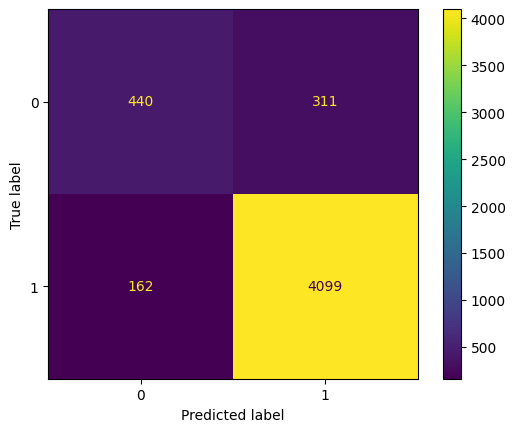

In [ ]:
# Tune & compare XGB models
XGB_Tuned2 = XGB2_RandomSearch.best_estimator_
XGB2_RandomSearch_pred = XGB_Tuned2.predict(x2_test)

tuned_accuracy2 = accuracy_score(y2_test, XGB2_RandomSearch_pred)
tuned_precision2 = precision_score(y2_test, XGB2_RandomSearch_pred)
tuned_recall2 = recall_score(y2_test, XGB2_RandomSearch_pred)
tuned_roc_auc2 = roc_auc_score(y2_test, XGB2_RandomSearch_pred)

print('Test Accuracy:', tuned_accuracy2)
print('Test Precision:', tuned_precision2)
print('Test Recall:', tuned_recall2)
print('Test AUC:', tuned_roc_auc2)

print('Confusion Matrix for S2 Tuned XGB:')
XGB_cmds2 = ConfusionMatrixDisplay.from_predictions(y2_test, XGB_pred2)

In [ ]:
print("Performance Comparison (STAGE 2 Test Set):")
print("-" * 40)
print(f"{'Metric':<15} {'Default Model S2':<15} {'Tuned Model S2':<15}")
print("-" * 40)
print(f"{'Accuracy':<15} {default_accuracy2:<15.4f} {tuned_accuracy2:<15.4f}")
print(f"{'Precision':<15} {default_precision2:<15.4f} {tuned_precision2:<15.4f}")
print(f"{'Recall':<15} {default_recall2:<15.4f} {tuned_recall2:<15.4f}")
print(f"{'AUC':<15} {default_roc_auc2:<15.4f} {tuned_roc_auc2:<15.4f}")
print("-" * 40)

Performance Comparison (STAGE 2 Test Set):
----------------------------------------
Metric          Default Model S2 Tuned Model S2 
----------------------------------------
Accuracy        0.9056          0.9038         
Precision       0.9295          0.9270         
Recall          0.9620          0.9627         
AUC             0.7739          0.7663         
----------------------------------------


Tuning the XGBoost model does not provide any significant improvement on the performance metrics.




#### **Commentary**

Stage 2 introduced data related to student engagement, specifically authorised and unauthorised absences. This information created a more dynamic view of the student's interaction with their programme after enrolment.

Unauthorised absences which showed a negative correlation with academic success, allowed the models to gain a slightly better understanding of students who might be struggling to attend or engage. As a result, the models trained on this data showed a marginal improvement in predictive metrics, most significant improvement being in AUC: 3%. Tuning the models in this stage did not produce significant performance enhancements.

While the impact of the new features is limited of predictive capabilities, this stage is a step forward in understanding and leveraging behavioural indicators.

# Stage 3 data

In [ ]:
# File URL
file_url_3 = "classified"

**Stage 3: Pre-processing decisions**

- Remove any columns not useful in the analysis (LearnerCode).
- Remove columns with high cardinality (use >200 unique values, as a guideline for this data set).
- Remove columns with >50% data missing.
- Perform ordinal encoding for ordinal data.
- Perform one-hot encoding for all other categorical data.
- Impute missing data rows with appropriate values.
- Remove rows with missing values in cases where rows with missing values are minimal: <2% of the overall data.






In [ ]:
data_s3 = pd.read_csv(file_url_3)
data_s3.head()

,CentreName,LearnerCode,BookingType,LeadSource,DiscountType,DateofBirth,Gender,Nationality,HomeState,HomeCity,...,CourseName,IsFirstIntake,CompletedCourse,AssessedModules,PassedModules,FailedModules,ProgressionDegree,ProgressionUniversity,AuthorisedAbsenceCount,UnauthorisedAbsenceCount
0,ISC_Aberdeen,2284932,Agent,Standard Agent Booking,NaN,13/01/1998,Male,Chinese,Jianye District; Jiangsu Province,Nanjing,...,Business and Law Pre-Masters,True,Yes,4.0,4.0,0.0,Msc Econ Accounting and Investment Management,University of Aberdeen,NaN,NaN
1,ISC_Aberdeen,2399500,Agent,Standard Agent Booking,NaN,12/2/1998,Male,Chinese,NaN,Xi'an,...,Life Sciences Undergraduate Foundation Programme,False,Yes,7.0,7.0,0.0,BSc Biological Sciences,University of Aberdeen,93.0,5.0
2,ISC_Aberdeen,2424946,Agent,Standard Agent Booking,NaN,7/4/2000,Male,Chinese,NaN,Chengdu,...,Business Management and Finance International ...,False,Yes,8.0,8.0,0.0,MA Finance,University of Aberdeen,92.0,6.0
3,ISC_Aberdeen,2426583,Agent,Standard Agent Booking,NaN,18/05/1999,Male,Chinese,NaN,LIUYANG CITY ;CHANGSHA,...,Business Management and Finance International ...,True,Yes,8.0,8.0,0.0,MA Business Management,University of Aberdeen,67.0,15.0
4,ISC_Aberdeen,2434674,Agent,Standard Agent Booking,NaN,19/04/1996,Male,Chinese,NaN,Xiamen,...,Business and Law Pre-Masters,True,Yes,4.0,4.0,0.0,MSc International Business Management,University of Aberdeen,NaN,NaN


In [ ]:
# Dataset characteristics
data_s3.info()
print('\n Unique values per feature \n', data_s3.nunique())
print('\n Missing values per feature \n', data_s3.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25059 entries, 0 to 25058
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CentreName                25059 non-null  object 
 1   LearnerCode               25059 non-null  int64  
 2   BookingType               25059 non-null  object 
 3   LeadSource                25059 non-null  object 
 4   DiscountType              7595 non-null   object 
 5   DateofBirth               25059 non-null  object 
 6   Gender                    25059 non-null  object 
 7   Nationality               25059 non-null  object 
 8   HomeState                 8925 non-null   object 
 9   HomeCity                  21611 non-null  object 
 10  CourseLevel               25059 non-null  object 
 11  CourseName                25059 non-null  object 
 12  IsFirstIntake             25059 non-null  bool   
 13  CompletedCourse           25059 non-null  object 
 14  Assess

In [ ]:
# Convert data types
data_s3['DateofBirth'] = pd.to_datetime(data_s3['DateofBirth'], dayfirst=True)
today = pd.Timestamp.now()
data_s3['Age'] = (today - data_s3['DateofBirth']).dt.days / 365.25
data_s3['Age'] = data_s3['Age'].round().astype(int)

# Convert Target variable Yes & No column to boolean values
data_s3['CompletedCourse'] = data_s3['CompletedCourse'].map({'Yes': 1, 'No': 0}) #.astype(bool)
data_s3['IsFirstIntake'] = data_s3['IsFirstIntake'].astype(int)

# Drop irrelevant columns
data_s3.drop(['LearnerCode','DateofBirth','HomeCity','HomeState','DiscountType', 'ProgressionDegree'], axis=1, inplace=True)

In [ ]:
# Select rows where there is missing data
data_s3[data_s3[['FailedModules','PassedModules','AssessedModules']].isnull().any(axis=1)]

,CentreName,BookingType,LeadSource,Gender,Nationality,CourseLevel,CourseName,IsFirstIntake,CompletedCourse,AssessedModules,PassedModules,FailedModules,ProgressionUniversity,AuthorisedAbsenceCount,UnauthorisedAbsenceCount,Age
6,ISC_Aberdeen,Agent,Standard Agent Booking,Male,Chinese,Foundation,Business; Economics; Accounting and Real Estat...,0,0,NaN,NaN,NaN,University of Aberdeen,29.0,18.0,23
84,ISC_Aberdeen,Agent,Standard Agent Booking,Female,Angolan,Foundation,Humanities; Law and Social Science Undergradua...,0,0,NaN,NaN,NaN,University of Aberdeen,6.0,20.0,24
103,ISC_Aberdeen,Agent,Standard Agent Booking,Male,Taiwanese,Foundation,Physical Sciences and Engineering Undergraduat...,0,0,NaN,NaN,NaN,University of Aberdeen,7.0,29.0,25
108,ISC_Aberdeen,Direct,APD,Male,Chinese,International Year Two,Business Management and Finance International ...,0,0,NaN,NaN,NaN,University of Aberdeen,8.0,32.0,24
140,ISC_Aberdeen,Agent,Standard Agent Booking,Female,Ugandan,Pre-Masters,Business and Law Pre-Masters,0,0,NaN,NaN,NaN,University of Aberdeen,NaN,NaN,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25032,ISC_Teesside,Agent,Standard Agent Booking,Male,Bangladeshi,Foundation,International Foundation Year Business; Humani...,0,0,NaN,NaN,NaN,Teesside University,0.0,63.0,23
25035,ISC_Teesside,Agent,Standard Agent Booking,Male,Bangladeshi,Foundation,International Foundation Year Business; Humani...,0,0,NaN,NaN,NaN,Teesside University,0.0,48.0,23
25036,ISC_Teesside,Agent,Standard Agent Booking,Male,Bangladeshi,Foundation,International Foundation Year Business; Humani...,0,0,NaN,NaN,NaN,Teesside University,0.0,60.0,21
25042,ISC_Teesside,Agent,Standard Agent Booking,Male,Sri Lankan,Foundation,International Foundation Year Business; Humani...,0,0,NaN,NaN,NaN,Teesside University,0.0,49.0,27


In [ ]:
#data_s3.drop(data_s3[data_s3[['FailedModules','PassedModules','AssessedModules']].isnull().any(axis=1)].index, inplace=True)

In [ ]:
data_s3.describe().round(2)

,IsFirstIntake,CompletedCourse,AssessedModules,PassedModules,FailedModules,AuthorisedAbsenceCount,UnauthorisedAbsenceCount,Age
count,25059.00,25059.00,22828.00,22828.00,22828.00,24851.00,24851.00,25059.00
mean,0.12,0.85,6.09,5.58,0.51,15.12,40.49,24.99
std,0.33,0.36,1.81,2.36,1.30,28.92,39.03,3.17
min,0.00,0.00,1.00,0.00,0.00,0.00,0.00,19.00
25%,0.00,1.00,4.00,4.00,0.00,0.00,12.00,23.00
50%,0.00,1.00,6.00,6.00,0.00,1.00,29.00,24.00
75%,0.00,1.00,7.00,7.00,0.00,15.00,56.00,27.00
max,1.00,1.00,12.00,11.00,10.00,292.00,343.00,63.00


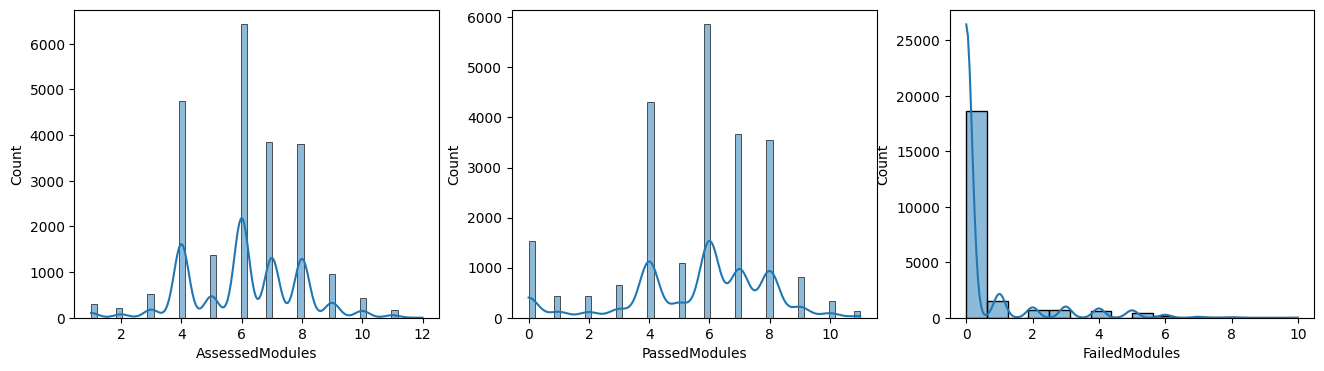

In [ ]:
# Plotted the distributions of the new features
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
sns.histplot(data_s3['AssessedModules'], kde=True)
plt.subplot(1,3,2)
sns.histplot(data_s3['PassedModules'], kde=True)
plt.subplot(1,3,3)
sns.histplot(data_s3['FailedModules'], kde=True)
plt.show()

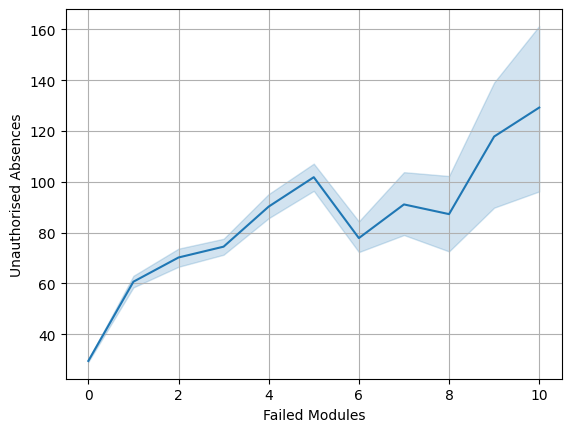

In [ ]:
# Explore the relationship between failed modules & abscences
sns.lineplot(data_s3,x='FailedModules',y='UnauthorisedAbsenceCount',)
plt.xlabel('Failed Modules')
plt.ylabel('Unauthorised Absences')
plt.grid()

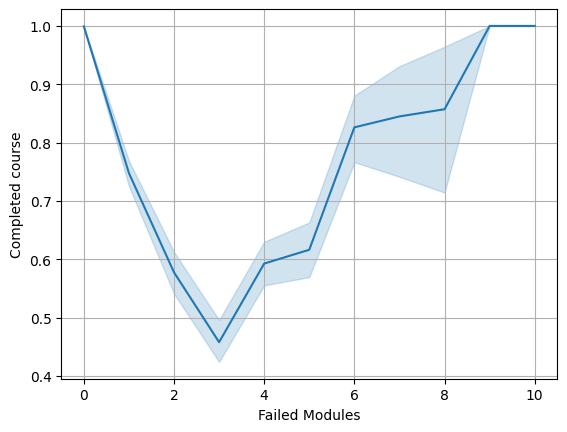

In [ ]:
# Explore the relationship between failed modules & course completion
sns.lineplot(data_s3,x='FailedModules',y='CompletedCourse',)
plt.xlabel('Failed Modules')
plt.ylabel('Completed course')
plt.grid()

The first graph is indicative of the significant relationship between Unauthorised Absences and Failed modules.


The second figure highlights that failing up to three modules is associated with a marked decrease in the likelihood of course completion, with the lowest completion rates observed around 3 failed modules. This suggests that early accumulation of failed modules may be a strong indicator of potential dropout risk. However, beyond this point, completion rates increase, indicating a non-linear relationship.


The evaluation of models built on Stage 3 data will further validate these observed relationships.

<Axes: >

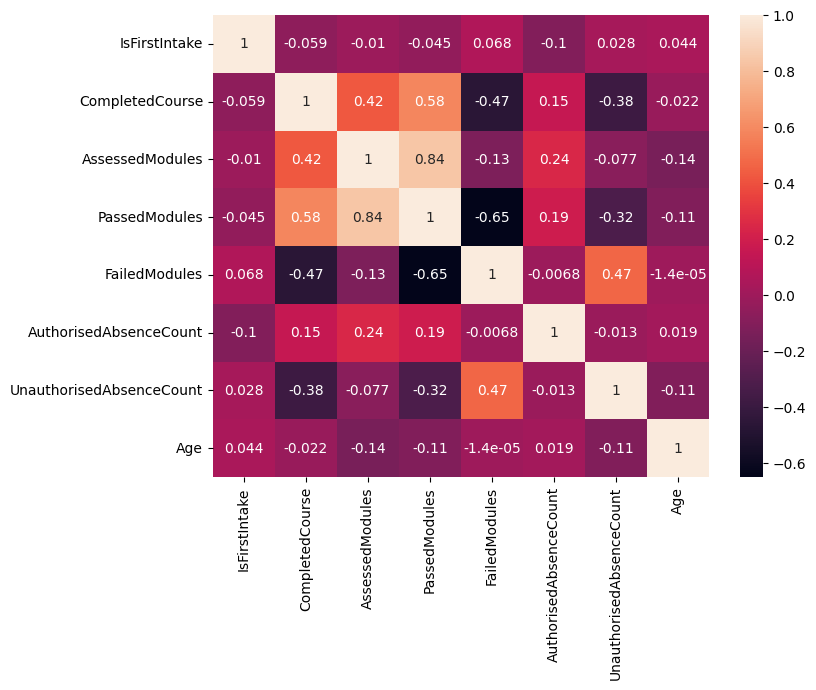

In [ ]:
# Explore correlations between numeric variables & target(Completed course)
plt.figure(figsize=(8,6))
sns.heatmap(data_s3.corr(numeric_only=True),annot=True)

The additional features introduced into the Stage 3 dataset provide us with more detailed insights into the relationship between student progress and the target variable.

In particular, a moderate to strong positive correlation was observed between the number of modules a student has undergone formal assessment in, the number of modules passed, and the likelihood of Course completion. This aligns with the intuitive understanding that academic progress is a key indicator of successful programme completion.

Conversely, there was a notable negative correlation between the number of failed modules and the probability of Course completion. Similarly, Unauthorised Absence Count demonstrated a negative relationship with course completion likelihood, and a positive relationship with FailedModules. These observations suggest that academic difficulties and lack of engagement, as reflected by failed modules and unauthorized absences, are significant indicators of potential student dropout.



In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Select columns to impute using Iterative imputer
cols_to_impute = ['FailedModules', 'PassedModules', 'AssessedModules', 'AuthorisedAbsenceCount', 'UnauthorisedAbsenceCount']
data_subset = data_s3[cols_to_impute]

# Create the imputer
imputer = IterativeImputer(random_state=42, sample_posterior=False)

# Fit and transform
imputed_data = pd.DataFrame(imputer.fit_transform(data_subset), columns=cols_to_impute)

# Replace the original columns with imputed ones
data_s3[cols_to_impute] = imputed_data

Around 9% of the newly added features were missing values. Removing these rows was considered, but this would have resulted in a substantial loss of valuable information. The **Iterative Imputer** was selected for filling in the missing values due to its more advanced predictive method based on observed data. This approach was further supported by the moderate correlation found between 'Unauthorised Absence Count' and both 'Passed Modules' and 'Failed Modules', highlighting the interconnectedness of these features.

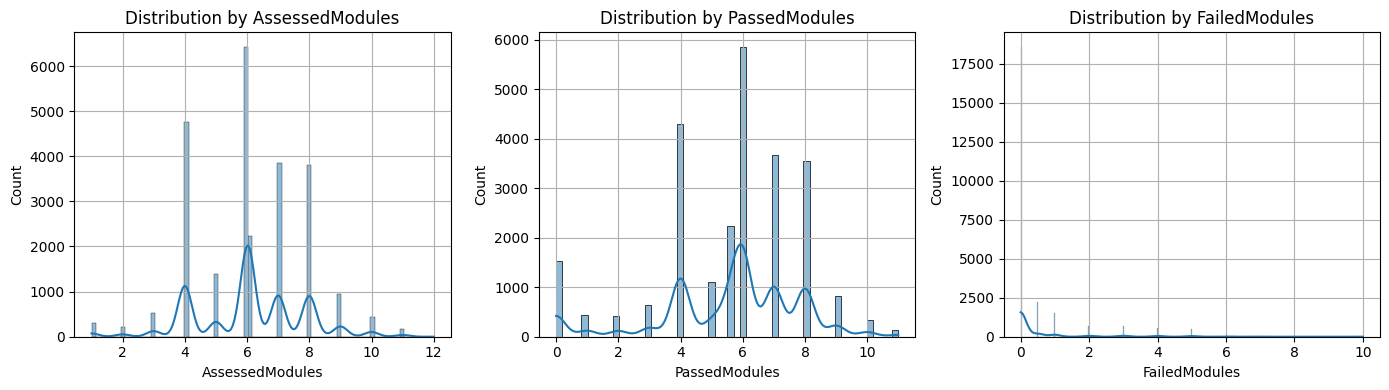

In [ ]:
# Review new features post-imputation
new_varbls = ['AssessedModules', 'PassedModules', 'FailedModules']

plt.figure(figsize=(14,4))

for i, col in enumerate(new_varbls):
    plt.subplot(1,len(new_varbls),i+1)
    sns.histplot(data=data_s3[new_varbls],x=col,kde=True)
    plt.title(f'Distribution by {col}')
    plt.grid()
    plt.tight_layout()

In [ ]:
# Preserved the distribution of the Y variable
data_s3['CompletedCourse'].value_counts(normalize=True).round(2)

,proportion
CompletedCourse,
1,0.85
0,0.15


In [ ]:
# Encode features
data_s3 = pd.get_dummies(data_s3,columns=['CentreName','BookingType','LeadSource','Gender','Nationality','CourseName','ProgressionUniversity'],
                      dtype=int)

OE = OrdinalEncoder(categories=[['Foundation','International Year One', 'International Year Two', 'Pre-Masters']])
data_s3['CourseLevel'] = OE.fit_transform(data_s3[['CourseLevel']])
data_s3['CourseLevel'] = data_s3['CourseLevel'].astype(int)

# Split data
y3 = data_s3['CompletedCourse'].copy()
x3 = data_s3.drop(['CompletedCourse'],axis=1).copy()
x3_train, x3_test, y3_train, y3_test = train_test_split(x3,y3,test_size=0.2,random_state=42,stratify=y3)

# Scale the training data (necessary for the NN, non-consequential for XGBoost)
scaler = RobustScaler()
sc_features = ['FailedModules', 'PassedModules', 'AssessedModules', 'AuthorisedAbsenceCount', 'UnauthorisedAbsenceCount', 'Age']
x3_train[sc_features] = scaler.fit_transform(x3_train[sc_features])
x3_test[sc_features] = scaler.transform(x3_test[sc_features])

# Define the Training & Validation sets for the NN
nn_x3_train, nn_x3_val, nn_y3_train, nn_y3_val = train_test_split(x3_train, y3_train, test_size=0.1, random_state=42,stratify=y3_train)

## Neural Network - Stage 3

In [ ]:
# NN
NN_Dropout3 = Sequential([
Input(shape=(nn_x3_train.shape[1],)),
Dense(400,activation='relu'),
Dense(200,activation='relu'),
Dense(1,activation='sigmoid')])

NN_Dropout3.summary()

# Define the evaluation metrics
keras_metrics = ['accuracy', 'precision', 'recall', 'AUC']
early_stop = EarlyStopping(monitor="val_loss", patience=5,
                           min_delta=0.001,
                           verbose=1,mode="auto", restore_best_weights=False,)

# Process pipeline
NN_Dropout3.compile(loss='binary_crossentropy', optimizer='rmsprop',metrics=keras_metrics)
History_3 = NN_Dropout3.fit(nn_x3_train, nn_y3_train, epochs=50, batch_size=64, validation_data=(nn_x3_val, nn_y3_val),callbacks=early_stop, verbose=1) # verbose=2
Evaluation_3 = NN_Dropout3.evaluate(x3_test, y3_test)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 400)            │       160,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 200)            │        80,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241,201 (942.19 KB)

 Trainable params: 241,201 (942.19 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.9487 - accuracy: 0.9118 - loss: 0.1936 - precision: 0.9374 - recall: 0.9603 - val_AUC: 0.9913 - val_accuracy: 0.9791 - val_loss: 0.0743 - val_precision: 0.9787 - val_recall: 0.9971
Epoch 2/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.9960 - accuracy: 0.9796 - loss: 0.0536 - precision: 0.9874 - recall: 0.9886 - val_AUC: 0.9963 - val_accuracy: 0.9890 - val_loss: 0.0399 - val_precision: 0.9912 - val_recall: 0.9959
Epoch 3/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.9976 - accuracy: 0.9870 - loss: 0.0344 - precision: 0.9919 - recall: 0.9927 - val_AUC: 0.9965 - val_accuracy: 0.9865 - val_loss: 0.0402 - val_precision: 0.9929 - val_recall: 0.9912
Epoch 4/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.9985 - accuracy: 0.9898 - loss: 0.0275 - precision: 0.9929 - recall: 0.9951 - val_AUC: 0.9968 - val_accuracy: 0.9776 - val_loss: 0.0573 - val_precision: 0.9935 - val_recall: 0.9801
Epoch 5/50
282/282 ━━━━━━━━━━━━━

In [ ]:
# Stage 3 Model evaluation
print('Test Accuracy:', Evaluation_3[1])
print('Test Precision:', Evaluation_3[2])
print('Test Recall:', Evaluation_3[3])
print('Test AUC:', Evaluation_3[4])

Test Accuracy: 0.9884277582168579
Test Precision: 0.9918090105056763
Test Recall: 0.9946022033691406
Test AUC: 0.9933174252510071


## XGBoost - Stage 3

Test Accuracy: 0.99122106943336
Test Precision: 0.9936782954811519
Test Recall: 0.9960103262145036
Test AUC: 0.9800291311498616
Confusion Matrix for S3 XGB:


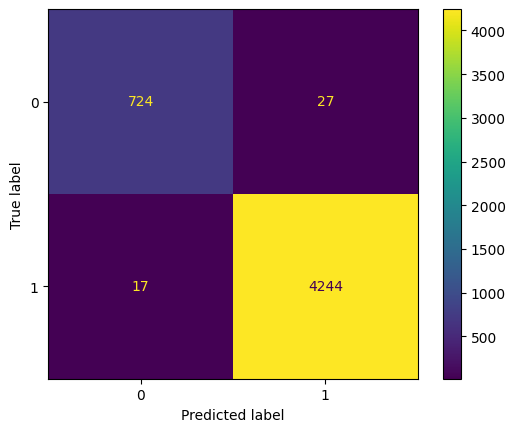

In [ ]:
# XGBOOST
## The XGBOOST model fitted on the training dataset
XGB_Dropped3 = XGBClassifier(random_state=42)
XG_trained3 = XGB_Dropped3.fit(x3_train, y3_train)
XGB_pred3 = XGB_Dropped3.predict(x3_test)

# Calculate the metric performances for the XGB model
default_accuracy3 = accuracy_score(y3_test, XGB_pred3)
default_precision3 = precision_score(y3_test, XGB_pred3)
default_recall3 = recall_score(y3_test, XGB_pred3)
default_roc_auc3 = roc_auc_score(y3_test, XGB_pred3)

print('Test Accuracy:', default_accuracy3)
print('Test Precision:', default_precision3)
print('Test Recall:', default_recall3)
print('Test AUC:', default_roc_auc3)

print('Confusion Matrix for S3 XGB:')
XGB_cmds3 = ConfusionMatrixDisplay.from_predictions(y3_test, XGB_pred3)

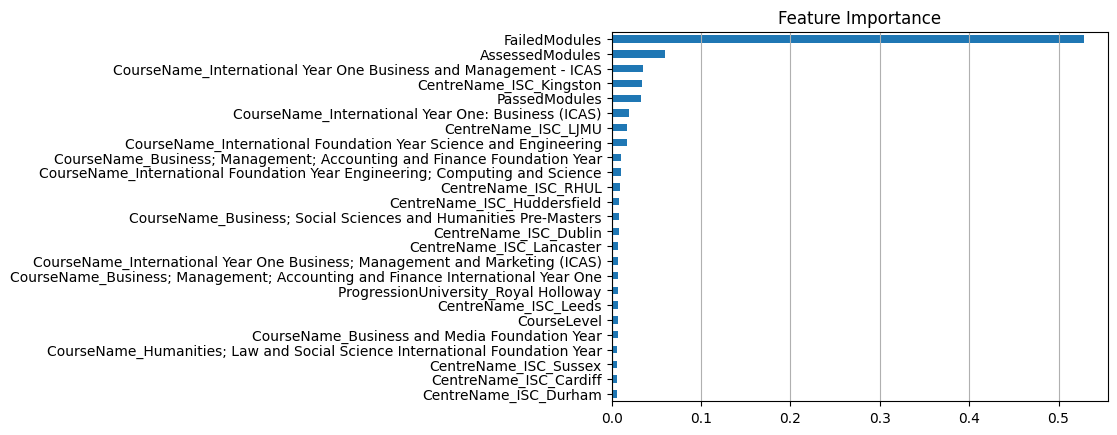

In [ ]:
# Plotting the feature importance
feature_importance = pd.Series(XG_trained3.feature_importances_, index=x3_train.columns).sort_values()
feature_importance.iloc[-25:].plot.barh(title='Feature Importance') # showing only the top most 25
plt.grid(axis='x')

The newly generated feature importance plot applied to the stage 3 data highlights that Academic performance, and in particular Failed modules is the primary driver of the model’s predictions. Other notable features are specific course and centre names; those however have a significantly lower impact.

This supports the earlier hypothesis that failing more than 2 modules is a strong dropout indicator.

### **Tuning the models for Stage 3**:

Given the strong performance achieved by both the XGBoost and Neural Network models on the Stage 3 dataset, as evidenced by the evaluation metrics, further hyperparameter tuning was not deemed necessary. The current performance levels suggest that additional optimisation efforts would likely yield only marginal improvements.

## Final Comparison & Evaluation

In [ ]:
# Compare NN metrics across all 3 Stages
output_comparison_final = {'Stage 1': Evaluation, 'Stage 2': Evaluation_2, 'Stage 3': Evaluation_3}
metric_names_comp = ['Loss', 'Accuracy', 'Precision', 'Recall', 'AUC']
metrics_result_final = pd.DataFrame(output_comparison_final, index=metric_names_comp)

print("\nComparison of Neural Network performance across 3 Stages:")
display(metrics_result_final)


Comparison of Neural Network performance across 3 Stages:


,Stage 1,Stage 2,Stage 3
Loss,0.337396,0.246018,0.038016
Accuracy,0.880088,0.903432,0.988428
Precision,0.916856,0.933242,0.991809
Recall,0.944614,0.954705,0.994602
AUC,0.858962,0.908263,0.993317


In [ ]:
# Compare XGBoost metrics across all 3 Stages
print("Comparison of XGBoost Performance across Stages 1/2/3:")
print("-" * 60)
print(f"{'Metric':<15} {'XGB Stage 1':<15} {'XGB Stage 2':<15} {'XGB Stage 3':<15}")
print("-" * 60)
print(f"{'Accuracy':<15} {default_accuracy:<15.4f} {default_accuracy2:<15.4f} {default_accuracy3:<15.4f}")
print(f"{'Precision':<15} {default_precision:<15.4f} {default_precision2:<15.4f} {default_precision3:<15.4f}")
print(f"{'Recall':<15} {default_recall:<15.4f} {default_recall2:<15.4f} {default_recall3:<15.4f}")
print(f"{'AUC':<15} {default_roc_auc:<15.4f} {default_roc_auc2:<15.4f} {default_roc_auc3:<15.4f}")
print("-" * 60)

Comparison of XGBoost Performance across Stages 1/2/3:
------------------------------------------------------------
Metric          XGB Stage 1     XGB Stage 2     XGB Stage 3    
------------------------------------------------------------
Accuracy        0.8945          0.9056          0.9912         
Precision       0.9210          0.9295          0.9937         
Recall          0.9580          0.9620          0.9960         
AUC             0.7460          0.7739          0.9800         
------------------------------------------------------------


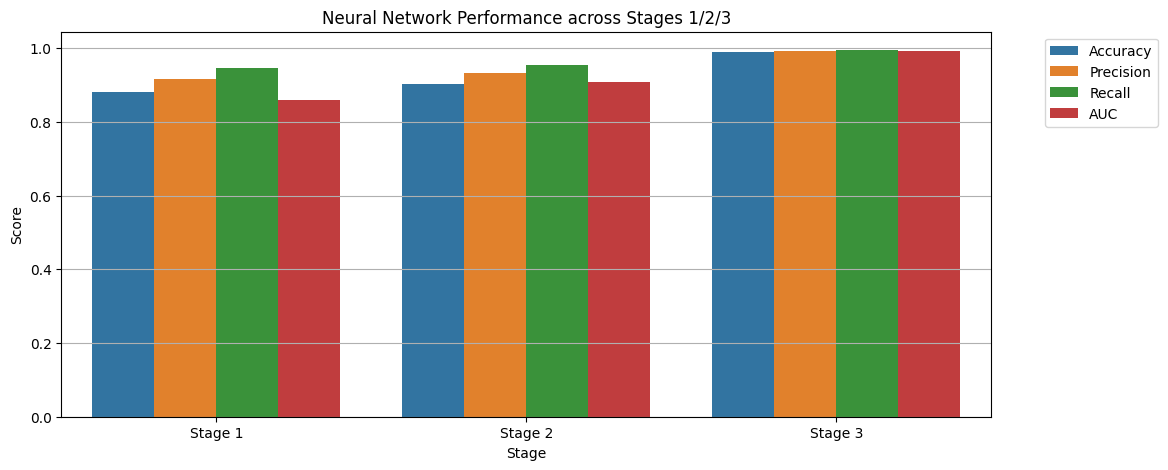



Comparison of Neural Network Performance across Stages 1/2/3:


,Stage 1,Stage 2,Stage 3
Accuracy,0.880088,0.903432,0.988428
Precision,0.916856,0.933242,0.991809
Recall,0.944614,0.954705,0.994602
AUC,0.858962,0.908263,0.993317


In [ ]:
# Visualise using Grouped bar-charts
# Reset index & melt dataframe to long form
metrics_result_final_ls = metrics_result_final.drop('Loss')
metrics_result_final_long = metrics_result_final_ls.reset_index().melt(id_vars='index', var_name='Stage', value_name='Score')
metrics_result_final_long = metrics_result_final_long.rename(columns={'index': 'Metric'})

plt.figure(figsize=(12,5))
plt.title('Neural Network Performance across Stages 1/2/3')
sns.barplot(metrics_result_final_long, x='Stage', y='Score', hue='Metric')
plt.ylabel('Score')
plt.grid(axis='y')
plt.legend(bbox_to_anchor=(1.05, 1),loc='upper left')
plt.show()

print('\n')
print("Comparison of Neural Network Performance across Stages 1/2/3:")
metrics_result_final_ls

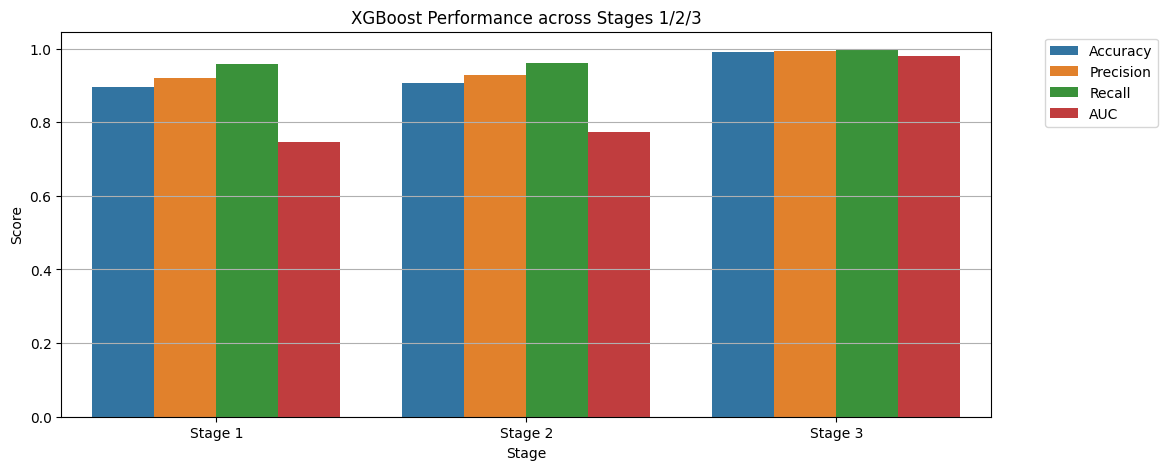



Comparison of XGBoost Performance across Stages 1/2/3:


,Stage 1,Stage 2,Stage 3
Accuracy,0.894453,0.905626,0.991221
Precision,0.921029,0.929478,0.993678
Recall,0.957991,0.961981,0.996010
AUC,0.745973,0.773933,0.980029


In [ ]:
# Group data in DF for convenience
XGB_metrics = {'Stage 1':[default_accuracy, default_precision, default_recall, default_roc_auc],
 'Stage 2':[default_accuracy2, default_precision2, default_recall2, default_roc_auc2],
 'Stage 3':[default_accuracy3, default_precision3, default_recall3, default_roc_auc3]}

metric_names = ['Accuracy', 'Precision', 'Recall', 'AUC']

XGB_metrics_df = pd.DataFrame(XGB_metrics, index=metric_names)

# Convert to long form...
XGB_metrics_long = XGB_metrics_df.reset_index().melt(id_vars='index', var_name='Stage', value_name='Score')
XGB_metrics_long = XGB_metrics_long.rename(columns={'index': 'Metric'})


plt.figure(figsize=(12,5))
plt.title('XGBoost Performance across Stages 1/2/3')
sns.barplot(data=XGB_metrics_long, x='Stage', y='Score', hue='Metric')
plt.ylabel('Score')
plt.grid(axis='y')
plt.legend(bbox_to_anchor=(1.05, 1),loc='upper left')
plt.show()

print('\n')
print("Comparison of XGBoost Performance across Stages 1/2/3:")
XGB_metrics_df

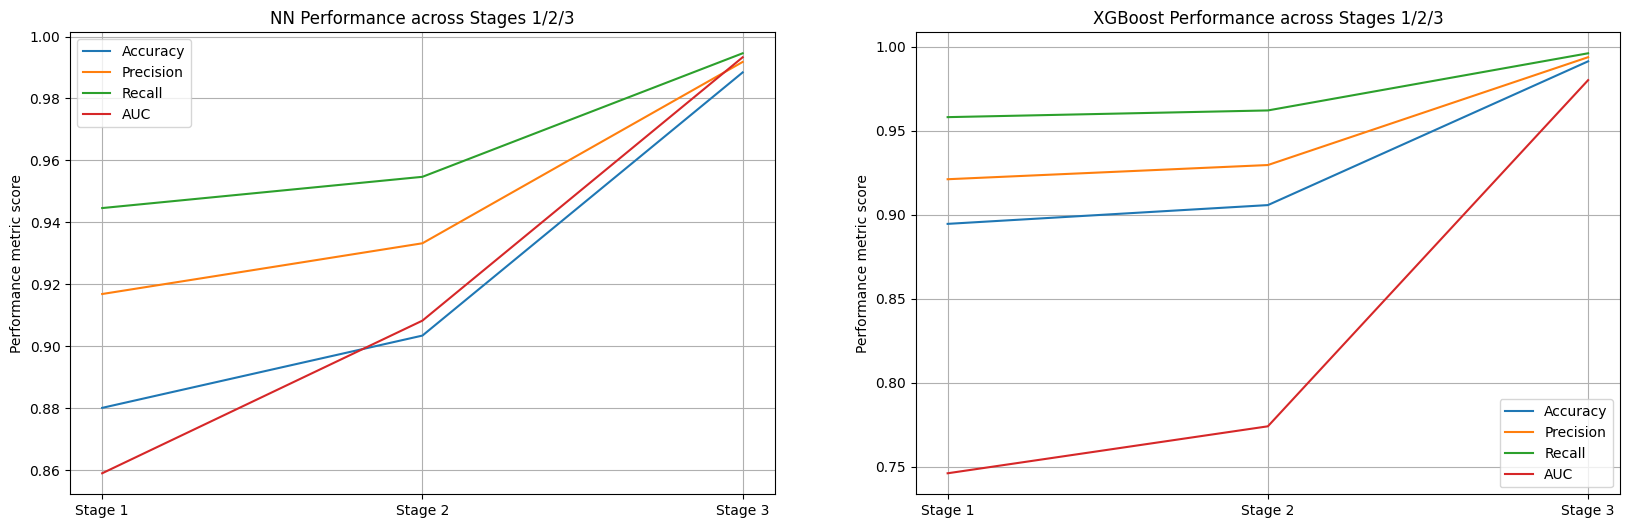

In [ ]:
# Plot linegraph for both models
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.title('NN Performance across Stages 1/2/3')
plt.plot(metrics_result_final.loc['Accuracy'])
plt.plot(metrics_result_final.loc['Precision'])
plt.plot(metrics_result_final.loc['Recall'])
plt.plot(metrics_result_final.loc['AUC'])
plt.ylabel('Performance metric score')
plt.legend(labels=['Accuracy', 'Precision', 'Recall', 'AUC'])
plt.grid()

plt.subplot(1,2,2)
plt.title('XGBoost Performance across Stages 1/2/3')
plt.plot(XGB_metrics_df.loc['Accuracy'])
plt.plot(XGB_metrics_df.loc['Precision'])
plt.plot(XGB_metrics_df.loc['Recall'])
plt.plot(XGB_metrics_df.loc['AUC'])
plt.ylabel('Performance metric score')
plt.legend(labels=['Accuracy', 'Precision', 'Recall', 'AUC'])
plt.grid()

plt.show()

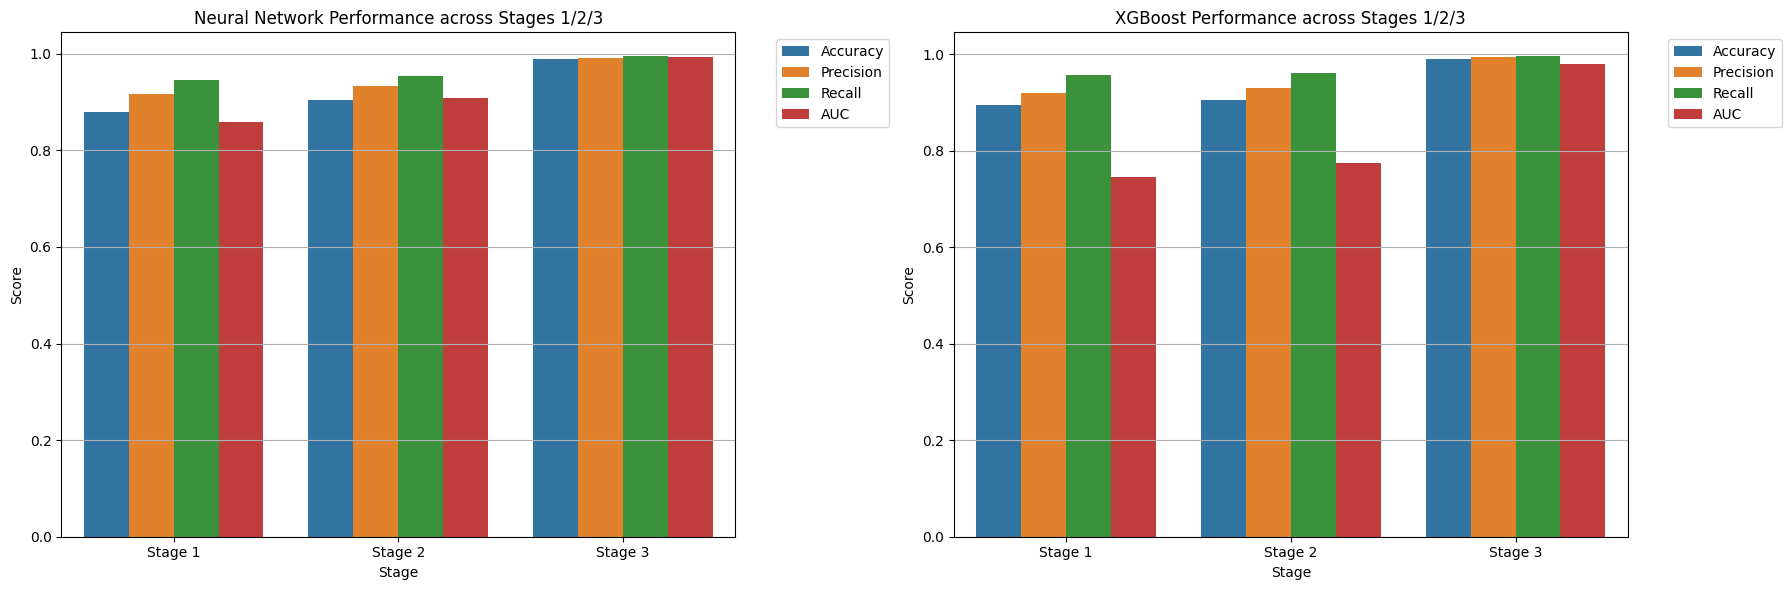

In [ ]:
# Plot Side-by-side Barchart for both models
plt.figure(figsize=(18,6))
# NN
plt.subplot(1,2,1)
plt.title('Neural Network Performance across Stages 1/2/3')
sns.barplot(metrics_result_final_long, x='Stage', y='Score', hue='Metric')
plt.ylabel('Score')
plt.grid(axis='y')
plt.legend(bbox_to_anchor=(1.05, 1),loc='upper left')
# XGB
plt.subplot(1,2,2)
plt.title('XGBoost Performance across Stages 1/2/3')
sns.barplot(data=XGB_metrics_long, x='Stage', y='Score', hue='Metric')
plt.ylabel('Score')
plt.grid(axis='y')
plt.legend(bbox_to_anchor=(1.05, 1),loc='upper left')

plt.tight_layout()
plt.show()

### **Commentary & Recommendations**:

Stage 3 incorporated crucial academic performance data, including assessed, passed, and failed modules. Correlation analysis indicated that academic performance is a strong indicator of a student's ability to succeed in their programme.

**Failing modules** was shown to have a strong negative correlation with course completion. By including these metrics into the analysis, the models were given powerful features directly reflecting the student's academic progress and difficulties. This resulted in a substantial increase in all metrics, including both AUC (98-99%) and Recall (99%), as the models could very accurately identify students who were at a higher risk of dropping out. Further parameter tuning was decided to be unnecessary due to the potentially marginal gains.


<br>

The conducted data exploration and analysis provided valuable insights into the factors influencing student dropout. To support client's goal of improving student retention, the following recommendations are proposed based on the observed patterns in the data:

- **Refine Candidate Vetting**: Conduct further investigation and incorporate predictive indicators identified in the application data into the admissions process to better evaluate dropout risk and provide tailored support for academic success.
- **Enhance Student Engagement Monitoring**: Integrate systems for continuous monitoring of student engagement metrics and develop automated alerts to flag students exhibiting decreasing attendance.
- **Strengthen Academic Support**: Design and implement targeted programmes for addressing academic learning challenges.